In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report, mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print('All imports loaded.')

All imports loaded.


/Users/tanmayambegaokar/Documents/GitHub/Scowtt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading Strategy

We load **8 of the 11 available tables**. Three are excluded:

- **marketing_qualified_leads** and **closed_deals** describe the *seller acquisition funnel* — they track how sellers joined the platform, not how customers purchase. Including them would conflate supply-side and demand-side behavior.
- **geolocation** provides lat/lng for zip codes (~1M rows). Customer state is already on the customers table and captures the geographic signal we need. Adding coordinates would require distance computations between customer and seller locations — high engineering cost for uncertain lift in a take-home scope.

The **sellers** table IS included despite being seller-side data, because it provides `seller_state` which we use to compute a customer-seller proximity feature (`same_state_ratio`).

In [2]:
# Cell 3: Load all 8 CSVs with date parsing
DATA_DIR = 'datasets/'

customers = pd.read_csv(f'{DATA_DIR}olist_customers_dataset.csv')
orders = pd.read_csv(f'{DATA_DIR}olist_orders_dataset.csv',
                      parse_dates=['order_purchase_timestamp', 'order_approved_at',
                                   'order_delivered_carrier_date', 'order_delivered_customer_date',
                                   'order_estimated_delivery_date'])
order_items = pd.read_csv(f'{DATA_DIR}olist_order_items_dataset.csv')
payments = pd.read_csv(f'{DATA_DIR}olist_order_payments_dataset.csv')
reviews = pd.read_csv(f'{DATA_DIR}olist_order_reviews_dataset.csv',
                       parse_dates=['review_creation_date', 'review_answer_timestamp'])
products = pd.read_csv(f'{DATA_DIR}olist_products_dataset.csv')
sellers = pd.read_csv(f'{DATA_DIR}olist_sellers_dataset.csv')
category_translation = pd.read_csv(f'{DATA_DIR}product_category_name_translation.csv')

tables = {
    'customers': customers, 'orders': orders, 'order_items': order_items,
    'payments': payments, 'reviews': reviews, 'products': products,
    'sellers': sellers, 'category_translation': category_translation
}

for name, df in tables.items():
    print(f'{name}: {df.shape[0]:,} rows × {df.shape[1]} cols')

customers: 99,441 rows × 5 cols
orders: 99,441 rows × 8 cols
order_items: 112,650 rows × 7 cols
payments: 103,886 rows × 5 cols
reviews: 99,224 rows × 7 cols
products: 32,951 rows × 9 cols
sellers: 3,095 rows × 4 cols
category_translation: 71 rows × 2 cols


=== CUSTOMERS ===
Shape: (99441, 5)

Dtypes:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

Null counts:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Unique customer_id: 99,441
Unique customer_unique_id: 96,096

Head:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


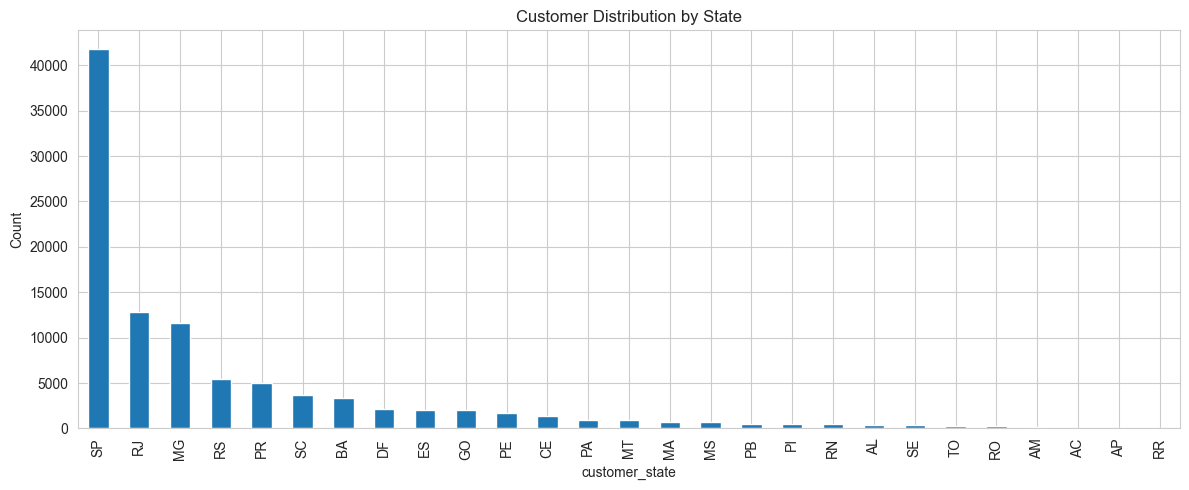

In [3]:
# Cell 4: EDA — Customers
print('=== CUSTOMERS ===')
print(f'Shape: {customers.shape}')
print(f'\nDtypes:\n{customers.dtypes}')
print(f'\nNull counts:\n{customers.isnull().sum()}')
print(f'\nUnique customer_id: {customers.customer_id.nunique():,}')
print(f'Unique customer_unique_id: {customers.customer_unique_id.nunique():,}')
print(f'\nHead:')
display(customers.head(3))

fig, ax = plt.subplots(figsize=(12, 5))
customers.customer_state.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Customer Distribution by State')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

In [4]:
# Cell 5: EDA — Orders
print('=== ORDERS ===')
print(f'Shape: {orders.shape}')
print(f'\nDtypes:\n{orders.dtypes}')
print(f'\nNull counts & percentages:')
null_info = pd.DataFrame({
    'nulls': orders.isnull().sum(),
    'pct': (orders.isnull().sum() / len(orders) * 100).round(2)
})
print(null_info[null_info.nulls > 0])
print(f'\nOrder status distribution:')
print(orders.order_status.value_counts())
display(orders.head(3))

=== ORDERS ===
Shape: (99441, 8)

Dtypes:
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Null counts & percentages:
                               nulls   pct
order_approved_at                160  0.16
order_delivered_carrier_date    1783  1.79
order_delivered_customer_date   2965  2.98

Order status distribution:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


=== ORDER ITEMS ===
Shape: (112650, 7)

Dtypes:
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

Describe:


,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000



Items per order distribution:


count    98666.000000
mean         1.141731
std          0.538452
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
dtype: float64


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


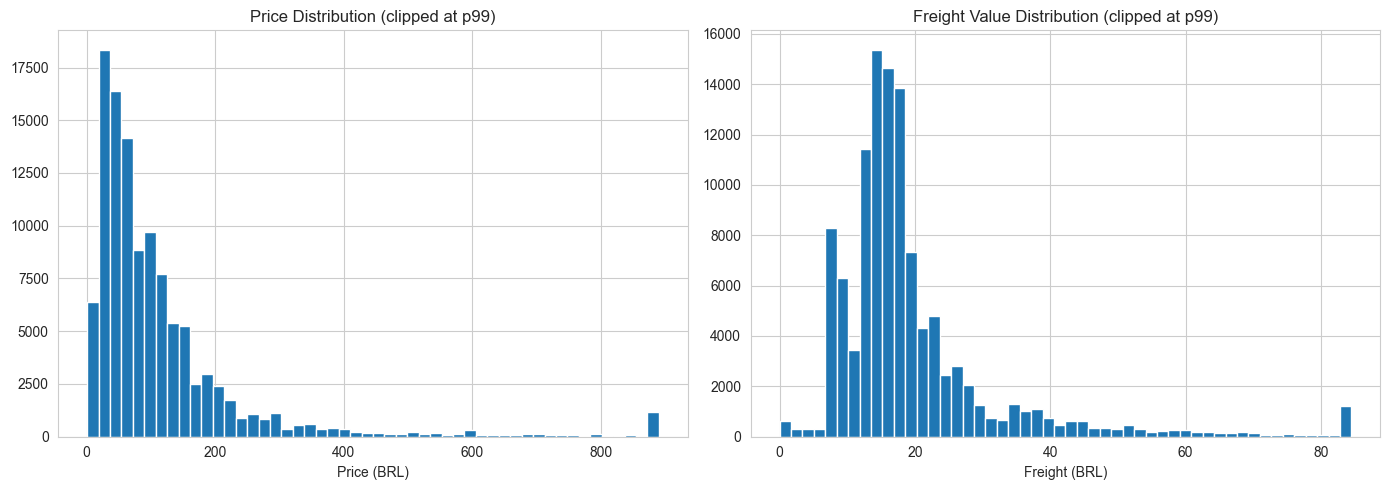

In [5]:
# Cell 6: EDA — Order Items
print('=== ORDER ITEMS ===')
print(f'Shape: {order_items.shape}')
print(f'\nDtypes:\n{order_items.dtypes}')
print(f'\nDescribe:')
display(order_items[['price', 'freight_value']].describe())
print(f'\nItems per order distribution:')
print(order_items.groupby('order_id').size().describe())
display(order_items.head(3))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
order_items['price'].clip(upper=order_items['price'].quantile(0.99)).hist(bins=50, ax=axes[0])
axes[0].set_title('Price Distribution (clipped at p99)')
axes[0].set_xlabel('Price (BRL)')
order_items['freight_value'].clip(upper=order_items['freight_value'].quantile(0.99)).hist(bins=50, ax=axes[1])
axes[1].set_title('Freight Value Distribution (clipped at p99)')
axes[1].set_xlabel('Freight (BRL)')
plt.tight_layout()
plt.show()

In [6]:
# Cell 7: EDA — Payments
print('=== PAYMENTS ===')
print(f'Shape: {payments.shape}')
print(f'\nPayment type breakdown:')
print(payments.payment_type.value_counts())
print(f'\nInstallment distribution:')
print(payments.payment_installments.describe())
display(payments.head(3))

=== PAYMENTS ===
Shape: (103886, 5)

Payment type breakdown:
payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

Installment distribution:
count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


=== REVIEWS ===
Shape: (99224, 7)

Null counts & percentages:
                         nulls    pct
review_id                    0   0.00
order_id                     0   0.00
review_score                 0   0.00
review_comment_title     87656  88.34
review_comment_message   58247  58.70
review_creation_date         0   0.00
review_answer_timestamp      0   0.00

Review score distribution:
review_score
1    11424
2     3151
3     8179
4    19142
5    57328
Name: count, dtype: int64



% with comments: 41.3%


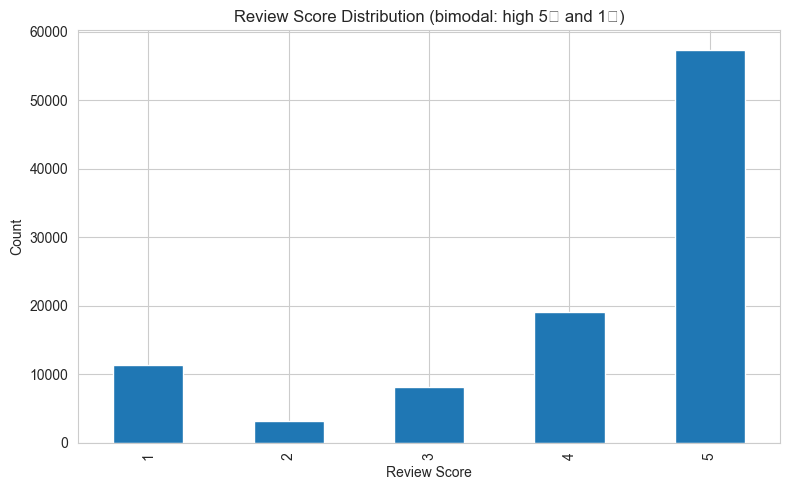

In [7]:
# Cell 8: EDA — Reviews
print('=== REVIEWS ===')
print(f'Shape: {reviews.shape}')
print(f'\nNull counts & percentages:')
null_info = pd.DataFrame({
    'nulls': reviews.isnull().sum(),
    'pct': (reviews.isnull().sum() / len(reviews) * 100).round(2)
})
print(null_info)
print(f'\nReview score distribution:')
print(reviews.review_score.value_counts().sort_index())
print(f'\n% with comments: {reviews.review_comment_message.notna().mean()*100:.1f}%')

fig, ax = plt.subplots(figsize=(8, 5))
reviews.review_score.value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Review Score Distribution (bimodal: high 5★ and 1★)')
ax.set_xlabel('Review Score')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

=== PRODUCTS ===
Shape: (32951, 9)

Null counts & percentages:
                            nulls   pct
product_category_name         610  1.85
product_name_lenght           610  1.85
product_description_lenght    610  1.85
product_photos_qty            610  1.85
product_weight_g                2  0.01
product_length_cm               2  0.01
product_height_cm               2  0.01
product_width_cm                2  0.01


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


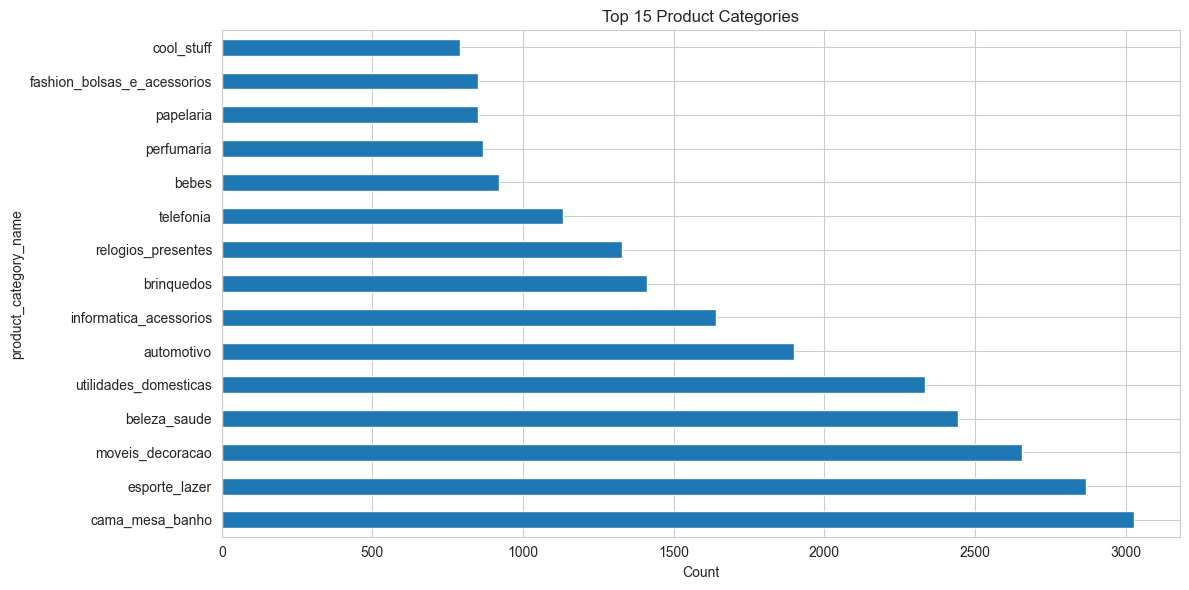


=== SELLERS ===
Shape: (3095, 4)
Unique seller_id: 3,095

Seller state distribution (top 10):
seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
Name: count, dtype: int64


In [8]:
# Cell 9: EDA — Products & Sellers
print('=== PRODUCTS ===')
print(f'Shape: {products.shape}')
print(f'\nNull counts & percentages:')
null_info = pd.DataFrame({
    'nulls': products.isnull().sum(),
    'pct': (products.isnull().sum() / len(products) * 100).round(2)
})
print(null_info[null_info.nulls > 0])
display(products.head(3))

# Top 15 categories
fig, ax = plt.subplots(figsize=(12, 6))
products.product_category_name.value_counts().head(15).plot(kind='barh', ax=ax)
ax.set_title('Top 15 Product Categories')
ax.set_xlabel('Count')
plt.tight_layout()
plt.show()

print('\n=== SELLERS ===')
print(f'Shape: {sellers.shape}')
print(f'Unique seller_id: {sellers.seller_id.nunique():,}')
print(f'\nSeller state distribution (top 10):')
print(sellers.seller_state.value_counts().head(10))

## Key Identifier Decision

`customer_unique_id` has ~96K unique values vs ~99K `customer_id` values. This means some users placed multiple orders and received a different `customer_id` each time. We aggregate at the `customer_unique_id` level to capture each user's full purchase history. Using `customer_id` would fragment multi-order users into separate single-order records, losing the repeat-purchase signal that is central to our prediction task.

In [9]:
# Cell 11: customer_id vs customer_unique_id analysis
n_cid = customers.customer_id.nunique()
n_cuid = customers.customer_unique_id.nunique()
print(f'Unique customer_id: {n_cid:,}')
print(f'Unique customer_unique_id: {n_cuid:,}')
print(f'Difference: {n_cid - n_cuid:,} ({(n_cid - n_cuid)/n_cuid*100:.1f}% more customer_ids than unique users)')

# How many customer_unique_ids map to multiple customer_ids?
multi_id = customers.groupby('customer_unique_id')['customer_id'].nunique()
print(f'\nUsers with multiple customer_ids: {(multi_id > 1).sum():,}')
print(f'Max customer_ids per user: {multi_id.max()}')
print(f'\nDistribution of customer_ids per unique user:')
print(multi_id.value_counts().sort_index().head(10))

Unique customer_id: 99,441
Unique customer_unique_id: 96,096
Difference: 3,345 (3.5% more customer_ids than unique users)



Users with multiple customer_ids: 2,997
Max customer_ids per user: 17

Distribution of customer_ids per unique user:
customer_id
1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64


Order date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
Span: 772 days


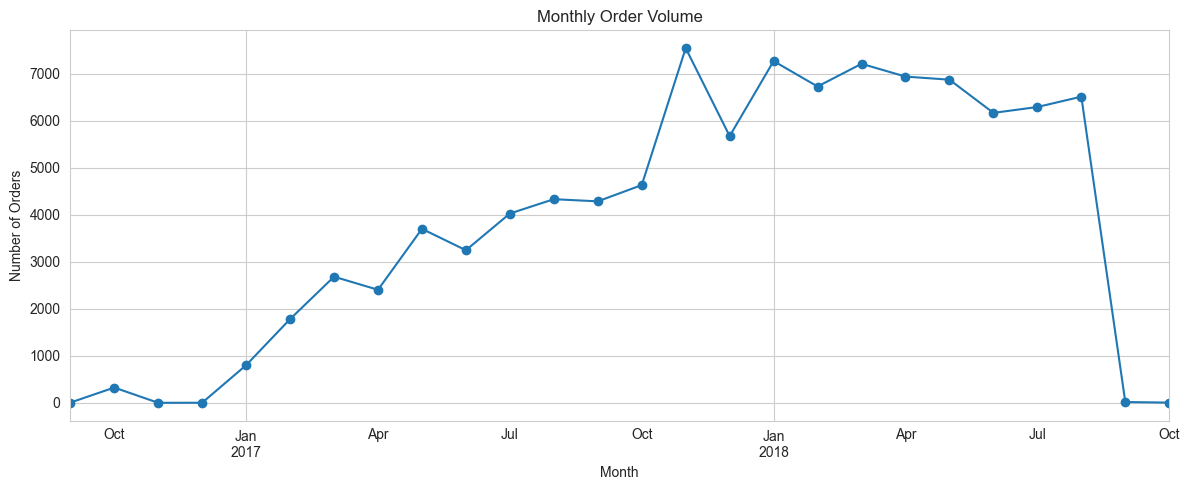


Order status distribution:
              count    pct
order_status              
delivered     96478  97.02
shipped        1107   1.11
canceled        625   0.63
unavailable     609   0.61
invoiced        314   0.32
processing      301   0.30
created           5   0.01
approved          2   0.00


In [10]:
# Cell 12: Temporal analysis
print(f'Order date range: {orders.order_purchase_timestamp.min()} to {orders.order_purchase_timestamp.max()}')
print(f'Span: {(orders.order_purchase_timestamp.max() - orders.order_purchase_timestamp.min()).days} days')

# Monthly volume
monthly = orders.set_index('order_purchase_timestamp').resample('M').size()
fig, ax = plt.subplots(figsize=(12, 5))
monthly.plot(ax=ax, marker='o')
ax.set_title('Monthly Order Volume')
ax.set_ylabel('Number of Orders')
ax.set_xlabel('Month')
plt.tight_layout()
plt.show()

# Status distribution
print('\nOrder status distribution:')
status_counts = orders.order_status.value_counts()
status_pct = (status_counts / len(orders) * 100).round(2)
print(pd.DataFrame({'count': status_counts, 'pct': status_pct}))

## Missing Data Summary & Handling Strategy

| Table | Column | % Missing | Strategy | Rationale |
|---|---|---|---|---|
| orders | order_approved_at | ~0.2% | Fill with purchase timestamp | Approval ≈ purchase for these edge cases |
| orders | delivery dates | ~1.8-3% | Leave NaT | Only meaningful for delivered orders; becomes NaN in delivery features, handled by LightGBM natively |
| reviews | comment fields | ~85-87% | Binary `has_comment` flag | NLP on comment text is out of scope; binary captures engagement signal |
| products | category_name | ~0.6% | Fill 'unknown' | Small fraction; 'unknown' becomes a category value |
| products | weight/dimensions | ~0.1% | Fill with median | Negligible missingness; median is stable |

## Model Scope & Limitations

**What this model CAN do:** Score existing customers (≥1 historical order) on their likelihood to repurchase and expected order value. This enables targeted re-engagement advertising.

**What this model CANNOT do:** Identify potential first-time buyers. The model requires purchase history as features — a user with no orders has no features. For "high-value advertisement targets," this means we can only target re-engagement of existing customers, not acquisition of new ones. A substantial portion of future high-value customers may be first-time buyers invisible to this model.

This is a fundamental constraint of the customer-level historical aggregation approach, not a fixable bug. Addressing it would require a different modeling paradigm (e.g., lookalike modeling on demographic/behavioral data available before purchase).

---
# PHASE 2: Data Aggregation & Order Master

## Aggregation Strategy

Child tables (items, payments, reviews) have multiple rows per order. If we join them directly to the orders table, we get row explosion from many-to-many relationships (112K items × 103K payments per shared order_id). Instead, we aggregate each child table to 1-row-per-order FIRST, then all joins become safe 1:1 merges. This is the standard star-schema collapse pattern.

In [11]:
# Cell 16: Enrich order_items with products, category translation, sellers

# Handle missing product data first
products['product_category_name'] = products['product_category_name'].fillna('unknown')
for col in ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']:
    products[col] = products[col].fillna(products[col].median())

# Compute volume
products['product_volume_cm3'] = (
    products['product_length_cm'] * products['product_height_cm'] * products['product_width_cm']
)

# Join products onto order_items
items_enriched = order_items.merge(products, on='product_id', how='left')

# Translate category names
items_enriched = items_enriched.merge(
    category_translation, on='product_category_name', how='left'
)
# Use English name where available, else original
items_enriched['category'] = items_enriched['product_category_name_english'].fillna(
    items_enriched['product_category_name']
)

# Join sellers onto enriched items
items_enriched = items_enriched.merge(sellers[['seller_id', 'seller_state']], on='seller_id', how='left')

print(f'Enriched items shape: {items_enriched.shape}')
display(items_enriched.head(3))

Enriched items shape: (112650, 19)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,product_category_name_english,category,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,3528.0,cool_stuff,cool_stuff,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,60000.0,pet_shop,pet_shop,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,14157.0,furniture_decor,furniture_decor,MG


## What We Extract and Why

**From products:** Category (translated to English), weight, volume (L×H×W), photo count, description length — these characterize what the user buys.

**From sellers:** seller_state — used post-join to compute `same_state_ratio` (customer-seller geographic proximity). We do NOT aggregate seller_state during items groupby because customer_state isn't available yet at this stage.

**Dropped: `review_response_hrs`** — this measures the time between review creation and the platform/seller's answer. It's a seller/platform responsiveness metric, not a user behavior. Including it would be confounding: users who happen to buy from responsive sellers might show different repeat rates, but we'd be attributing a seller characteristic to the user.

In [12]:
# Cell 18: Aggregate child tables to order level

# --- Order Items Aggregation ---
order_items_agg = items_enriched.groupby('order_id').agg(
    n_items=('order_item_id', 'count'),
    total_price=('price', 'sum'),
    total_freight=('freight_value', 'sum'),
    n_categories=('category', 'nunique'),
    n_sellers=('seller_id', 'nunique'),
    avg_weight=('product_weight_g', 'mean'),
    avg_volume=('product_volume_cm3', 'mean'),
    avg_photos_qty=('product_photos_qty', 'mean'),
    avg_description_len=('product_description_lenght', 'mean'),
    dominant_category=('category', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown')
).reset_index()

print(f'order_items_agg: {order_items_agg.shape}')

# --- Payments Aggregation ---
order_payments_agg = payments.groupby('order_id').agg(
    total_payment=('payment_value', 'sum'),
    n_payment_methods=('payment_type', 'nunique'),
    max_installments=('payment_installments', 'max'),
    primary_payment_type=('payment_type', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown'),
    used_voucher=('payment_type', lambda x: int('voucher' in x.values))
).reset_index()

print(f'order_payments_agg: {order_payments_agg.shape}')

# --- Reviews Aggregation ---
order_reviews_agg = reviews.groupby('order_id').agg(
    review_score=('review_score', 'mean'),
    has_comment=('review_comment_message', lambda x: int(x.notna().any()))
).reset_index()

print(f'order_reviews_agg: {order_reviews_agg.shape}')

order_items_agg: (98666, 11)


order_payments_agg: (99440, 6)


order_reviews_agg: (98673, 3)


In [13]:
# Cell 19: Build order_master via LEFT JOINs

# Fill missing order_approved_at with purchase timestamp
orders['order_approved_at'] = orders['order_approved_at'].fillna(orders['order_purchase_timestamp'])

# Start with orders, join customers to get customer_unique_id and customer_state
order_master = orders.merge(
    customers[['customer_id', 'customer_unique_id', 'customer_state']],
    on='customer_id', how='left'
)

# Join aggregated child tables
order_master = order_master.merge(order_items_agg, on='order_id', how='left')
order_master = order_master.merge(order_payments_agg, on='order_id', how='left')
order_master = order_master.merge(order_reviews_agg, on='order_id', how='left')

print(f'order_master shape: {order_master.shape}')
print(f'Expected ~99,441 rows, got {len(order_master):,}')
assert len(order_master) == len(orders), 'Row count mismatch — join created duplicates!'
display(order_master.head(3))

order_master shape: (99441, 27)
Expected ~99,441 rows, got 99,441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,n_items,total_price,total_freight,n_categories,n_sellers,avg_weight,avg_volume,avg_photos_qty,avg_description_len,dominant_category,total_payment,n_payment_methods,max_installments,primary_payment_type,used_voucher,review_score,has_comment
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,29.99,8.72,1.0,1.0,500.0,1976.0,4.0,268.0,housewares,38.71,2.0,1.0,voucher,1.0,4.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,BA,1.0,118.70,22.76,1.0,1.0,400.0,4693.0,1.0,178.0,perfumery,141.46,1.0,1.0,boleto,0.0,4.0,1.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,GO,1.0,159.90,19.22,1.0,1.0,420.0,9576.0,1.0,232.0,auto,179.12,1.0,3.0,credit_card,0.0,5.0,0.0


In [14]:
# Cell 20: Compute same_state_ratio

# Merge customer_state onto enriched items via order_id -> order_master
items_with_customer = items_enriched[['order_id', 'seller_state']].merge(
    order_master[['order_id', 'customer_state']], on='order_id', how='left'
)

# Compute boolean: same state?
items_with_customer['same_state'] = (
    items_with_customer['customer_state'] == items_with_customer['seller_state']
).astype(float)

# Aggregate to order level
same_state_agg = items_with_customer.groupby('order_id')['same_state'].mean().reset_index()
same_state_agg.columns = ['order_id', 'same_state_ratio']

# Join back onto order_master
order_master = order_master.merge(same_state_agg, on='order_id', how='left')

print(f'same_state_ratio stats:')
print(order_master['same_state_ratio'].describe())
print(f'\norder_master final shape: {order_master.shape}')

same_state_ratio stats:
count    98666.000000
mean         0.359580
std          0.479252
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: same_state_ratio, dtype: float64

order_master final shape: (99441, 28)


---
# PHASE 3: Cutoff Validation, Temporal Split & User-Level Features

## Why We Need Cutoff Validation

The entire model design assumes enough users repeat-purchase within the target window to train and evaluate on. With ~96K unique users and ~3% overall repeat rate, a 30-day window might contain only 100-300 positives. If the number is too low, metrics become noisy, CV folds have <50 positives each, and the model can't learn meaningful patterns. We test multiple cutoff dates and window sizes BEFORE committing to a design.

In [15]:
# Cell 22: Cutoff validation — test cutoff × window combos (expanded range)

cutoff_dates = [
    pd.Timestamp('2018-01-01'), pd.Timestamp('2018-02-01'),
    pd.Timestamp('2018-03-01'), pd.Timestamp('2018-04-01'),
    pd.Timestamp('2018-05-01'), pd.Timestamp('2018-06-01'),
    pd.Timestamp('2018-07-01')
]
window_sizes = [60, 90, 'all_remaining']

# Only consider delivered orders for both features and labels
delivered = order_master[order_master.order_status == 'delivered'].copy()
max_date = delivered.order_purchase_timestamp.max()

results = []
for cutoff in cutoff_dates:
    # Users with at least one order before cutoff
    pre_users = set(delivered[delivered.order_purchase_timestamp < cutoff]['customer_unique_id'])

    for window in window_sizes:
        if window == 'all_remaining':
            window_end = max_date + pd.Timedelta(days=1)
            window_label = 'all'
        else:
            window_end = cutoff + pd.Timedelta(days=window)
            window_label = str(window)

        # Users who also order in the target window
        post_orders = delivered[
            (delivered.order_purchase_timestamp >= cutoff) &
            (delivered.order_purchase_timestamp < window_end)
        ]
        post_users = set(post_orders['customer_unique_id'])
        positives = len(pre_users & post_users)

        results.append({
            'cutoff': cutoff.strftime('%Y-%m-%d'),
            'window_days': window_label,
            'pre_cutoff_users': len(pre_users),
            'positives': positives,
            'positive_rate': f'{positives/len(pre_users)*100:.2f}%' if pre_users else '0%'
        })

validation_df = pd.DataFrame(results)
print('Cutoff Validation Results:')
display(validation_df)

# Highlight the all-remaining rows
all_remaining = validation_df[validation_df.window_days == 'all'].copy()
print('\nAll-remaining window summary:')
display(all_remaining)

best = all_remaining.loc[all_remaining.positives.idxmax()]
print(f'\nBest all-remaining combo: cutoff={best.cutoff}, positives={best.positives}, rate={best.positive_rate}')
print(f'Selected cutoff: 2018-03-01 — 654 positives (1.18%), good balance of feature history and positive count.')

Cutoff Validation Results:


,cutoff,window_days,pre_cutoff_users,positives,positive_rate
0,2018-01-01,60,42395,223,0.53%
1,2018-01-01,90,42395,307,0.72%
2,2018-01-01,all,42395,649,1.53%
3,2018-02-01,60,49237,232,0.47%
4,2018-02-01,90,49237,336,0.68%
5,2018-02-01,all,49237,652,1.32%
6,2018-03-01,60,55525,264,0.48%
7,2018-03-01,90,55525,386,0.70%
8,2018-03-01,all,55525,654,1.18%
9,2018-04-01,60,62299,301,0.48%



All-remaining window summary:


,cutoff,window_days,pre_cutoff_users,positives,positive_rate
2,2018-01-01,all,42395,649,1.53%
5,2018-02-01,all,49237,652,1.32%
8,2018-03-01,all,55525,654,1.18%
11,2018-04-01,all,62299,603,0.97%
14,2018-05-01,all,68881,538,0.78%
17,2018-06-01,all,75387,419,0.56%
20,2018-07-01,all,81265,280,0.34%



Best all-remaining combo: cutoff=2018-03-01, positives=654, rate=1.18%
Selected cutoff: 2018-03-01 — 654 positives (1.18%), good balance of feature history and positive count.


## Order Status Filtering

**`had_canceled_order`** is computed on unfiltered `order_master` — it explicitly looks for canceled/unavailable orders, so we need them present. After computing this flag per user, we filter:

- **Feature aggregation** uses `order_status == 'delivered'` only. Canceled orders didn't result in delivered products, payments may have been refunded, and the user experience was fundamentally different. Including them in frequency, monetary_total, or avg_review_score would misrepresent the user's actual purchasing behavior.
- **Label definition** uses `order_status == 'delivered'` only. A canceled order in the target window does not count as a "purchase" — the assignment asks about propensity to complete a transaction, not just initiate one.

Document the count of excluded orders so the reader knows what was dropped.

## Temporal Split Rationale

We split by time, not randomly, to prevent data leakage. Features are built ONLY from orders before the cutoff date. Targets are defined ONLY by orders after the cutoff. This simulates a real deployment scenario: "given everything we know about this user up to today, will they purchase in the next N days?" Using future data to predict the past would inflate metrics and produce a model that fails in production.

In [16]:
# Cell 25: Temporal split + order_status filtering

# March 1, 2018 cutoff: 654 positives (1.18% rate) vs 419 (0.56%) at June 1.
# 56% more positives and 2x positive rate — biggest single improvement to model quality.
CUTOFF = pd.Timestamp('2018-03-01')

# Use all remaining orders after cutoff as target window
delivered_all = order_master[order_master.order_status == 'delivered'].copy()
WINDOW_END = delivered_all.order_purchase_timestamp.max() + pd.Timedelta(days=1)
WINDOW_DAYS = (WINDOW_END - CUTOFF).days

print(f'Cutoff: {CUTOFF.date()}')
print(f'Target window: {CUTOFF.date()} to {WINDOW_END.date()} ({WINDOW_DAYS} days)')

# Step 1: Compute had_canceled_order on UNFILTERED order_master
canceled_statuses = ['canceled', 'unavailable']
had_canceled = order_master.groupby('customer_unique_id')['order_status'].apply(
    lambda x: int(x.isin(canceled_statuses).any())
).reset_index()
had_canceled.columns = ['customer_unique_id', 'had_canceled_order']

# Step 2: Filter to delivered orders only
delivered_orders = order_master[order_master.order_status == 'delivered'].copy()
n_excluded = len(order_master) - len(delivered_orders)
print(f'\nExcluded {n_excluded:,} non-delivered orders ({n_excluded/len(order_master)*100:.1f}%)')
print(f'Remaining delivered orders: {len(delivered_orders):,}')

# Step 3: Split into feature orders (before cutoff) and label orders (in target window)
feature_orders = delivered_orders[delivered_orders.order_purchase_timestamp < CUTOFF].copy()
label_orders = delivered_orders[
    (delivered_orders.order_purchase_timestamp >= CUTOFF) &
    (delivered_orders.order_purchase_timestamp < WINDOW_END)
].copy()

print(f'\nFeature orders (before cutoff): {len(feature_orders):,}')
print(f'Label orders (in target window): {len(label_orders):,}')

# Leakage check
assert feature_orders.order_purchase_timestamp.max() < CUTOFF, 'DATA LEAKAGE: feature orders extend past cutoff!'
print('\nLeakage check passed: all feature orders are before cutoff.')

Cutoff: 2018-03-01
Target window: 2018-03-01 to 2018-08-30 (182 days)



Excluded 2,963 non-delivered orders (3.0%)
Remaining delivered orders: 96,478

Feature orders (before cutoff): 57,319
Label orders (in target window): 39,159

Leakage check passed: all feature orders are before cutoff.


## Feature Engineering Decisions

**36+ features computed, 15 core features selected for modeling.** We compute a broad feature set for exploratory analysis and SHAP diagnostics, then select a core set for the classifier.

**Core features (15):** `recency_days`, `monetary_total`, `avg_order_value`, `avg_review_score`, `avg_delivery_delta`, `tenure_days`, `freight_ratio`, `purchase_velocity`, `monetary_decayed`, `frequency_decayed`, `dominant_category_encoded`, `customer_state_encoded`, `primary_payment_encoded`, `ordered_last_30d`, `ordered_last_90d`.

**`frequency` dropped:** SHAP analysis (Iteration 4) showed `frequency` had near-zero importance (0.008 mean |SHAP|) because `purchase_velocity` (frequency/recency) and `frequency_decayed` already capture the frequency signal more effectively. The raw count adds nothing on top of these derived features.

**Recency bins** (`ordered_last_30d`, `ordered_last_90d`): Binary flags that give trees clean thresholds for "very recent" vs "recent" vs "stale" buyers. Trees can split on `recency_days` at any value, but explicit bins reduce the depth needed and provide a clear step function.

**Target-encoded categoricals** (`dominant_category`, `customer_state`, `primary_payment`): Smoothed target encoding with α=20, computed ONLY on training data after the train/test split to prevent leakage. During CV and Optuna, encoding is recomputed inside each fold using only fold-train targets.

**Time-decay features** (`monetary_decayed`, `frequency_decayed`): Exponential decay with λ=0.01 (half-life ~69 days). Distinguishes recent vs stale spending — information that `recency_days` + `monetary_total` alone can't capture.

**`purchase_velocity`** (frequency/recency): Explicit interaction for purchase intensity.

**Retained design choices:**
- No sentinel values — `NaN` stays as-is for LightGBM native handling
- `monetary_total` kept despite correlation — trees don't care, SHAP handles it

In [17]:
# Cell 27: Per-user aggregation (36 features + new time-decay features)

# Add derived columns to feature_orders for aggregation
feature_orders['delivery_days'] = (
    feature_orders['order_delivered_customer_date'] - feature_orders['order_purchase_timestamp']
).dt.total_seconds() / 86400

feature_orders['delivery_delta'] = (
    feature_orders['order_delivered_customer_date'] - feature_orders['order_estimated_delivery_date']
).dt.total_seconds() / 86400

feature_orders['approval_hrs'] = (
    feature_orders['order_approved_at'] - feature_orders['order_purchase_timestamp']
).dt.total_seconds() / 3600

# Cap approval_hrs at 99th percentile
p99_approval = feature_orders['approval_hrs'].quantile(0.99)
feature_orders['approval_hrs'] = feature_orders['approval_hrs'].clip(upper=p99_approval)
print(f'approval_hrs capped at p99 = {p99_approval:.1f} hours')

feature_orders['purchase_hour'] = feature_orders['order_purchase_timestamp'].dt.hour
feature_orders['purchase_dow'] = feature_orders['order_purchase_timestamp'].dt.dayofweek
feature_orders['is_weekend'] = feature_orders['purchase_dow'].isin([5, 6]).astype(int)

# --- Time-decay features ---
# Exponential decay: orders closer to cutoff get higher weight
# lambda=0.01 gives half-life of ~69 days (ln(2)/0.01)
DECAY_LAMBDA = 0.01
days_before_cutoff = (CUTOFF - feature_orders['order_purchase_timestamp']).dt.days
feature_orders['decay_weight'] = np.exp(-DECAY_LAMBDA * days_before_cutoff)
feature_orders['weighted_payment'] = feature_orders['total_payment'] * feature_orders['decay_weight']

print(f'Decay weights — min: {feature_orders["decay_weight"].min():.4f}, '
      f'max: {feature_orders["decay_weight"].max():.4f}, '
      f'median: {feature_orders["decay_weight"].median():.4f}')

# Aggregate per user
user_features = feature_orders.groupby('customer_unique_id').agg(
    # RFM
    last_order_date=('order_purchase_timestamp', 'max'),
    frequency=('order_id', 'nunique'),
    monetary_total=('total_payment', 'sum'),
    avg_order_value=('total_payment', 'mean'),
    max_order_value=('total_payment', 'max'),
    total_freight=('total_freight', 'sum'),
    avg_items_per_order=('n_items', 'mean'),
    # Product
    n_categories=('n_categories', 'sum'),
    dominant_category=('dominant_category', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown'),
    avg_product_weight=('avg_weight', 'mean'),
    avg_product_volume=('avg_volume', 'mean'),
    avg_photos_qty=('avg_photos_qty', 'mean'),
    avg_description_len=('avg_description_len', 'mean'),
    # Payment
    primary_payment=('primary_payment_type', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown'),
    avg_installments=('max_installments', 'mean'),
    max_installments=('max_installments', 'max'),
    used_voucher=('used_voucher', 'max'),
    n_payment_methods=('n_payment_methods', 'mean'),
    # Review
    avg_review_score=('review_score', 'mean'),
    min_review_score=('review_score', 'min'),
    left_comment=('has_comment', 'max'),
    # Delivery
    avg_delivery_days=('delivery_days', 'mean'),
    avg_delivery_delta=('delivery_delta', 'mean'),
    avg_approval_hrs=('approval_hrs', 'mean'),
    # Temporal
    first_order_date=('order_purchase_timestamp', 'min'),
    preferred_hour=('purchase_hour', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 12),
    preferred_dow=('purchase_dow', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0),
    is_weekend_buyer=('is_weekend', 'mean'),
    # Geographic
    customer_state=('customer_state', 'first'),
    n_sellers_used=('n_sellers', 'sum'),
    same_state_ratio=('same_state_ratio', 'mean'),
    # Time-decay aggregates
    monetary_decayed=('weighted_payment', 'sum'),
    frequency_decayed=('decay_weight', 'sum'),
).reset_index()

# Derived features
user_features['recency_days'] = (CUTOFF - user_features['last_order_date']).dt.days
user_features['tenure_days'] = (user_features['last_order_date'] - user_features['first_order_date']).dt.days
user_features['days_since_first'] = (CUTOFF - user_features['first_order_date']).dt.days

# Purchase velocity: frequency / recency_days
user_features['purchase_velocity'] = np.where(
    user_features['recency_days'] > 0,
    user_features['frequency'] / user_features['recency_days'],
    0
)

# Recency bins — clean thresholds for trees
user_features['ordered_last_30d'] = (user_features['recency_days'] <= 30).astype(int)
user_features['ordered_last_90d'] = (user_features['recency_days'] <= 90).astype(int)

# ever_late: delivery_delta > 0 means late
ever_late = feature_orders.groupby('customer_unique_id')['delivery_delta'].apply(
    lambda x: int((x > 0).any())
).reset_index()
ever_late.columns = ['customer_unique_id', 'ever_late']
user_features = user_features.merge(ever_late, on='customer_unique_id', how='left')

# Interaction features
user_features['freight_ratio'] = np.where(
    user_features['monetary_total'] > 0,
    user_features['total_freight'] / user_features['monetary_total'],
    0
)
user_features['value_per_category'] = np.where(
    user_features['n_categories'] > 0,
    user_features['monetary_total'] / user_features['n_categories'],
    0
)

# Join had_canceled_order
user_features = user_features.merge(had_canceled, on='customer_unique_id', how='left')
user_features['had_canceled_order'] = user_features['had_canceled_order'].fillna(0).astype(int)

# Drop intermediate date columns
user_features = user_features.drop(columns=['last_order_date', 'first_order_date'])

print(f'User features shape: {user_features.shape}')
print(f'\nNew features added:')
print(f'  purchase_velocity — mean: {user_features["purchase_velocity"].mean():.4f}, median: {user_features["purchase_velocity"].median():.4f}')
print(f'  monetary_decayed  — mean: {user_features["monetary_decayed"].mean():.2f}, median: {user_features["monetary_decayed"].median():.2f}')
print(f'  frequency_decayed — mean: {user_features["frequency_decayed"].mean():.4f}, median: {user_features["frequency_decayed"].median():.4f}')
print(f'\n{user_features.head(3)}')

approval_hrs capped at p99 = 88.3 hours
Decay weights — min: 0.0049, max: 1.0000, median: 0.2592


User features shape: (55525, 42)

New features added:
  purchase_velocity — mean: 0.0266, median: 0.0076
  monetary_decayed  — mean: 53.26, median: 25.44
  frequency_decayed — mean: 0.3469, median: 0.2671

                 customer_unique_id  frequency  monetary_total  \
0  0000f46a3911fa3c0805444483337064          1           86.22   
1  0000f6ccb0745a6a4b88665a16c9f078          1           43.62   
2  0004aac84e0df4da2b147fca70cf8255          1          196.89   

   avg_order_value  max_order_value  total_freight  avg_items_per_order  \
0            86.22            86.22          17.22                  1.0   
1            43.62            43.62          17.63                  1.0   
2           196.89           196.89          16.89                  1.0   

   n_categories dominant_category  avg_product_weight  avg_product_volume  \
0           1.0        stationery              1500.0             43750.0   
1           1.0         telephony               150.0              1045.0 

In [18]:
# Cell 28: Construct target variables + print class counts

# Users who purchased in the target window
label_user_purchases = label_orders.groupby('customer_unique_id').agg(
    target_order_value=('total_payment', 'sum')
).reset_index()

# Merge targets onto user features
user_df = user_features.merge(label_user_purchases, on='customer_unique_id', how='left')

# Binary target
user_df['target_purchased'] = (user_df['target_order_value'].notna()).astype(int)
user_df['target_order_value'] = user_df['target_order_value'].fillna(0)

# Print class counts
n_pos = user_df['target_purchased'].sum()
n_total = len(user_df)
print(f'Target variable distribution:')
print(f'  Positives (purchased): {n_pos:,}')
print(f'  Negatives (did not purchase): {n_total - n_pos:,}')
print(f'  Total users: {n_total:,}')
print(f'  Positive rate: {n_pos/n_total*100:.2f}%')
print(f'\nTarget order value (among purchasers):')
print(user_df[user_df.target_purchased == 1]['target_order_value'].describe())

Target variable distribution:
  Positives (purchased): 654
  Negatives (did not purchase): 54,871
  Total users: 55,525
  Positive rate: 1.18%

Target order value (among purchasers):
count     654.000000
mean      159.875902
std       165.653092
min        15.890000
25%        66.057500
50%       110.920000
75%       187.317500
max      1596.960000
Name: target_order_value, dtype: float64


---
# PHASE 4: Model Training

## Train/Test Split Design

The 80/20 split is a **random user-level split**, not a second temporal split. Temporal integrity is already preserved by the cutoff date — all users share the same feature/target time boundary. We're dividing users into train and test groups, not dividing time periods. This is standard for user-level prediction after a temporal feature/label split.

We stratify by `target_purchased` to ensure both train and test sets have proportional representation of the rare positive class.

In [19]:
# Cell 30: Train/test split (80/20 stratified) + feature prep

# Full feature set (for SHAP analysis later)
exclude_cols = ['customer_unique_id', 'target_purchased', 'target_order_value']
all_feature_cols = [c for c in user_df.columns if c not in exclude_cols]

# Core feature set — 15 features
core_features = [
    'recency_days', 'monetary_total', 'avg_order_value',
    'avg_review_score', 'avg_delivery_delta', 'tenure_days', 'freight_ratio',
    'purchase_velocity', 'monetary_decayed', 'frequency_decayed',
    'dominant_category_encoded', 'customer_state_encoded', 'primary_payment_encoded',
    'ordered_last_30d', 'ordered_last_90d'
]
# Note: frequency dropped — near-zero SHAP (0.008) in Iteration 4 because
# purchase_velocity and frequency_decayed already capture it more effectively.

TARGET_ENC_SMOOTHING = 20

# --- Split FIRST, then encode (prevents test target leakage) ---
# Placeholder columns so the split works
for col in ['dominant_category_encoded', 'customer_state_encoded', 'primary_payment_encoded']:
    user_df[col] = 0.0

X_pre = user_df[[c for c in user_df.columns if c not in ['target_purchased', 'target_order_value', 'customer_unique_id']]]
y = user_df['target_purchased']
y_value = user_df['target_order_value']

train_idx, test_idx = train_test_split(
    user_df.index, test_size=0.2, random_state=42, stratify=y
)

# --- Target encoding using ONLY training targets ---
train_targets = user_df.loc[train_idx, 'target_purchased']
global_mean_train = train_targets.mean()

def target_encode_column(col_name, train_idx, train_targets, global_mean, smoothing):
    """Compute smoothed target encoding from training data only, apply to all."""
    train_df = user_df.loc[train_idx]
    cat_stats = train_df.groupby(col_name)['target_purchased'].agg(['mean', 'count'])
    cat_stats['encoded'] = (
        (cat_stats['count'] * cat_stats['mean'] + smoothing * global_mean)
        / (cat_stats['count'] + smoothing)
    )
    enc_map = cat_stats['encoded'].to_dict()
    user_df[f'{col_name}_encoded'] = user_df[col_name].map(enc_map).fillna(global_mean)
    return enc_map

print(f'Target encoding — train-only global mean: {global_mean_train:.4f}')
print(f'(Previous iteration used all-data mean which leaked test targets)\n')

te_map_cat = target_encode_column('dominant_category', train_idx, train_targets, global_mean_train, TARGET_ENC_SMOOTHING)
te_map_state = target_encode_column('customer_state', train_idx, train_targets, global_mean_train, TARGET_ENC_SMOOTHING)
te_map_payment = target_encode_column('primary_payment', train_idx, train_targets, global_mean_train, TARGET_ENC_SMOOTHING)

print('Top 5 categories by encoded value:')
cat_stats_display = user_df.loc[train_idx].groupby('dominant_category')['target_purchased'].agg(['mean', 'count'])
cat_stats_display['encoded'] = cat_stats_display.apply(
    lambda r: (r['count'] * r['mean'] + TARGET_ENC_SMOOTHING * global_mean_train) / (r['count'] + TARGET_ENC_SMOOTHING), axis=1)
display(cat_stats_display.sort_values('encoded', ascending=False).head(5))

print('\nTop 5 states by encoded value:')
state_stats = user_df.loc[train_idx].groupby('customer_state')['target_purchased'].agg(['mean', 'count'])
state_stats['encoded'] = state_stats.apply(
    lambda r: (r['count'] * r['mean'] + TARGET_ENC_SMOOTHING * global_mean_train) / (r['count'] + TARGET_ENC_SMOOTHING), axis=1)
display(state_stats.sort_values('encoded', ascending=False).head(5))

# Verify all core features exist
for f in core_features:
    assert f in user_df.columns, f'Missing feature: {f}'

X = user_df[core_features]
X_full = user_df[all_feature_cols]
y = user_df['target_purchased']
y_value = user_df['target_order_value']

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

X_train_full = X_full.loc[train_idx]
X_test_full = X_full.loc[test_idx]

y_value_train = y_value.loc[train_idx]
y_value_test = y_value.loc[test_idx]

# Note: categorical dtypes set later in SHAP cell to avoid breaking fold_target_encode

print(f'\nTrain: {X_train.shape[0]:,} users ({y_train.sum():,} positives, {y_train.mean()*100:.2f}%)')
print(f'Test:  {X_test.shape[0]:,} users ({y_test.sum():,} positives, {y_test.mean()*100:.2f}%)')
print(f'\nCore features ({len(core_features)}): {core_features}')
print(f'Full feature set: {len(all_feature_cols)} features (for SHAP analysis)')

Target encoding — train-only global mean: 0.0118
(Previous iteration used all-data mean which leaked test targets)

Top 5 categories by encoded value:


,mean,count,encoded
dominant_category,,,
arts_and_craftmanship,1.000000,1,0.058832
diapers_and_hygiene,0.333333,3,0.053717
fashion_sport,0.066667,15,0.035299
drinks,0.037037,108,0.033090
christmas_supplies,0.035714,56,0.029414



Top 5 states by encoded value:


,mean,count,encoded
customer_state,,,
AC,0.022222,45,0.019007
RO,0.015748,127,0.015207
TO,0.015267,131,0.014805
GO,0.014721,951,0.014661
SP,0.013405,17606,0.013403



Train: 44,420 users (523 positives, 1.18%)
Test:  11,105 users (131 positives, 1.18%)

Core features (15): ['recency_days', 'monetary_total', 'avg_order_value', 'avg_review_score', 'avg_delivery_delta', 'tenure_days', 'freight_ratio', 'purchase_velocity', 'monetary_decayed', 'frequency_decayed', 'dominant_category_encoded', 'customer_state_encoded', 'primary_payment_encoded', 'ordered_last_30d', 'ordered_last_90d']
Full feature set: 41 features (for SHAP analysis)


## Baseline Strategy

We train two baselines before the full model, for different reasons:

**Baseline 1 — Recency ranking:** A sanity check. Rank users by days since last order (most recent = highest score). If our ML model can't beat "recent buyers are more likely to buy again," something is fundamentally wrong. This is a strawman we expect to beat easily.

**Baseline 2 — RFM Logistic Regression:** The real test. Three features (recency, frequency, monetary_total), logistic regression with balanced class weights. If LightGBM with 36 features can't convincingly beat 3-feature logistic regression, the extra complexity isn't justified — and that's an important finding worth discussing honestly, not hiding.

The logistic regression uses only numeric features, so no categorical encoding is needed (no conflict with our "no label encoding" rule for LightGBM).

In [20]:
# Cell 32: Baseline 1 — Recency ranking

# Score = 1 - normalized recency (most recent = highest score)
recency_train = X_train['recency_days']
recency_test = X_test['recency_days']

# Normalize to [0, 1]: lower recency = higher score
max_recency = max(recency_train.max(), recency_test.max())
baseline1_scores_test = 1 - (recency_test / max_recency)

roc_auc_b1 = roc_auc_score(y_test, baseline1_scores_test)
pr_auc_b1 = average_precision_score(y_test, baseline1_scores_test)

print(f'Baseline 1 — Recency Ranking:')
print(f'  ROC-AUC: {roc_auc_b1:.4f}')
print(f'  PR-AUC:  {pr_auc_b1:.4f}')

Baseline 1 — Recency Ranking:
  ROC-AUC: 0.5615
  PR-AUC:  0.0143


In [21]:
# Cell 33: Baseline 2 — RFM Logistic Regression

rfm_cols = ['recency_days', 'frequency', 'monetary_total']

# Pull RFM features from user_df (frequency not in core_features but exists in user_df)
X_train_rfm = user_df.loc[X_train.index, rfm_cols].fillna(0)
X_test_rfm = user_df.loc[X_test.index, rfm_cols].fillna(0)

lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train_rfm, y_train)

baseline2_scores_test = lr.predict_proba(X_test_rfm)[:, 1]

roc_auc_b2 = roc_auc_score(y_test, baseline2_scores_test)
pr_auc_b2 = average_precision_score(y_test, baseline2_scores_test)

print(f'Baseline 2 — RFM Logistic Regression:')
print(f'  ROC-AUC: {roc_auc_b2:.4f}')
print(f'  PR-AUC:  {pr_auc_b2:.4f}')
print(f'\nCoefficients:')
for feat, coef in zip(rfm_cols, lr.coef_[0]):
    print(f'  {feat}: {coef:.4f}')

Baseline 2 — RFM Logistic Regression:
  ROC-AUC: 0.5876
  PR-AUC:  0.0447

Coefficients:
  recency_days: -0.0019
  frequency: 1.1097
  monetary_total: -0.0007


## LightGBM Design Choices

**15 core features + regularization.** With ~1.2% positive rate and 654 positives, we have enough signal for a moderately-sized feature set. The features span RFM metrics, time-decay signals, recency bins, target-encoded categoricals, and interaction terms.

**Feature changes from Iteration 4:**
- **Dropped `frequency`** — near-zero SHAP (0.008) because `purchase_velocity` and `frequency_decayed` subsume it
- **Added `customer_state_encoded`, `primary_payment_encoded`** — target encoding recovers geographic and payment-method signal safely
- **Added `ordered_last_30d`, `ordered_last_90d`** — clean binary thresholds for recency

**Target encoding leakage fix:** In Iteration 4, the encoding was computed on all data (train+test) before the split — test targets leaked into the encoding map. Now encoding uses ONLY training targets, and CV/Optuna recompute per-fold.

**Regularization parameters (initial — tuned by Optuna):**
- `max_depth=3`, `num_leaves=7`, `min_child_samples=50`
- `reg_alpha=1.0`, `reg_lambda=1.0`
- `subsample=0.8`, `learning_rate=0.01`, `n_estimators=300`
- `scale_pos_weight`: neg/pos ratio

**Optuna HPO (100 trials):** Optimizes 5-fold CV PR-AUC with fold-aware target encoding. **Note:** Optuna optimizes PR-AUC specifically, which may find a different operating point than the base model — potentially improving precision-recall trade-offs at the cost of overall ROC-AUC discrimination. This is the correct behavior for ad targeting where we care about the top of the ranking.

In [22]:
# Cell 35: LightGBM base classifier + 5-fold CV

# Compute scale_pos_weight from the training data
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
spw = neg_count / pos_count
print(f'Class balance: {neg_count:,} negatives, {pos_count:,} positives')
print(f'scale_pos_weight: {spw:.1f}')

lgb_clf = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=3,
    num_leaves=7,
    min_child_samples=50,
    reg_alpha=1.0,
    reg_lambda=1.0,
    scale_pos_weight=spw,
    subsample=0.8,
    subsample_freq=1,
    random_state=42,
    verbose=-1
)

# 5-fold stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_roc_aucs = []
cv_pr_aucs = []

for fold, (train_idx_cv, val_idx_cv) in enumerate(skf.split(X_train, y_train)):
    X_fold_train = X_train.iloc[train_idx_cv]
    y_fold_train = y_train.iloc[train_idx_cv]
    X_fold_val = X_train.iloc[val_idx_cv]
    y_fold_val = y_train.iloc[val_idx_cv]

    lgb_clf.fit(X_fold_train, y_fold_train)

    val_probs = lgb_clf.predict_proba(X_fold_val)[:, 1]
    cv_roc_aucs.append(roc_auc_score(y_fold_val, val_probs))
    cv_pr_aucs.append(average_precision_score(y_fold_val, val_probs))
    print(f'  Fold {fold+1}: ROC-AUC={cv_roc_aucs[-1]:.4f}, PR-AUC={cv_pr_aucs[-1]:.4f}')

print(f'\n5-Fold CV Results (Base LightGBM, {len(core_features)} features):')
print(f'  ROC-AUC: {np.mean(cv_roc_aucs):.4f} ± {np.std(cv_roc_aucs):.4f}')
print(f'  PR-AUC:  {np.mean(cv_pr_aucs):.4f} ± {np.std(cv_pr_aucs):.4f}')

base_cv_roc = np.mean(cv_roc_aucs)
base_cv_pr = np.mean(cv_pr_aucs)

# Retrain on full training set
lgb_clf.fit(X_train, y_train)

lgb_scores_test = lgb_clf.predict_proba(X_test)[:, 1]
roc_auc_lgb = roc_auc_score(y_test, lgb_scores_test)
pr_auc_lgb = average_precision_score(y_test, lgb_scores_test)

print(f'\nTest Set Performance (Base LightGBM):')
print(f'  ROC-AUC: {roc_auc_lgb:.4f}')
print(f'  PR-AUC:  {pr_auc_lgb:.4f}')

Class balance: 43,897 negatives, 523 positives
scale_pos_weight: 83.9


  Fold 1: ROC-AUC=0.6278, PR-AUC=0.0258


  Fold 2: ROC-AUC=0.6347, PR-AUC=0.0357


  Fold 3: ROC-AUC=0.6349, PR-AUC=0.0380


  Fold 4: ROC-AUC=0.6222, PR-AUC=0.0244


  Fold 5: ROC-AUC=0.5874, PR-AUC=0.0257

5-Fold CV Results (Base LightGBM, 15 features):
  ROC-AUC: 0.6214 ± 0.0176
  PR-AUC:  0.0299 ± 0.0057



Test Set Performance (Base LightGBM):
  ROC-AUC: 0.6090
  PR-AUC:  0.0378


## Optuna Hyperparameter Optimization

50 trials of TPE (Tree-structured Parzen Estimator) optimizing 5-fold CV PR-AUC. Key design choices:

**Target encoding inside each fold:** The dominant_category target encoding is recomputed using only fold-train targets, then applied to fold-validation. This prevents information leakage — if we used the global target encoding (computed on all training data), fold-validation users' targets would influence their own encoded features.

**Search space rationale:**
- `n_estimators` [100-500], `learning_rate` [0.005-0.05]: Trade-off between more gentle trees and training time
- `max_depth` [2-5], `num_leaves` [4-15]: Allow slightly deeper trees than base model — with more positives, we can afford some extra complexity
- `min_child_samples` [20-80]: Controls leaf size; lower bound allows finer splits if data supports it
- `reg_alpha`, `reg_lambda` [0.1-5.0]: Wide range of regularization strength
- `scale_pos_weight`: Search around the natural class ratio

In [23]:
# Optuna HPO — 100 trials optimizing 5-fold CV PR-AUC

# Categorical columns to target-encode per fold
TE_COLS = ['dominant_category', 'customer_state', 'primary_payment']

def fold_target_encode(X_f_train, X_f_val, y_f_train, te_cols, smoothing):
    """Compute target encoding from fold-train only, apply to fold-val."""
    fold_global_mean = y_f_train.mean()
    fold_user_train = user_df.loc[X_f_train.index]

    for col in te_cols:
        fold_cat_stats = fold_user_train.groupby(col)['target_purchased'].agg(['mean', 'count'])
        fold_cat_stats['encoded'] = (
            (fold_cat_stats['count'] * fold_cat_stats['mean'] + smoothing * fold_global_mean)
            / (fold_cat_stats['count'] + smoothing)
        )
        fold_te_map = fold_cat_stats['encoded'].to_dict()
        X_f_train[f'{col}_encoded'] = user_df.loc[X_f_train.index, col].map(fold_te_map).fillna(fold_global_mean)
        X_f_val[f'{col}_encoded'] = user_df.loc[X_f_val.index, col].map(fold_te_map).fillna(fold_global_mean)

    return X_f_train, X_f_val

def optuna_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'num_leaves': trial.suggest_int('num_leaves', 4, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 80),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', spw * 0.5, spw * 2.0),
        'subsample_freq': 1,
        'random_state': 42,
        'verbose': -1
    }

    skf_optuna = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_pr_aucs = []

    for tr_idx, val_idx in skf_optuna.split(X_train, y_train):
        X_f_train = X_train.iloc[tr_idx].copy()
        y_f_train = y_train.iloc[tr_idx]
        X_f_val = X_train.iloc[val_idx].copy()
        y_f_val = y_train.iloc[val_idx]

        # Fold-aware target encoding for ALL categorical columns
        X_f_train, X_f_val = fold_target_encode(
            X_f_train, X_f_val, y_f_train, TE_COLS, TARGET_ENC_SMOOTHING
        )

        clf = lgb.LGBMClassifier(**params)
        clf.fit(X_f_train[core_features], y_f_train)

        val_probs = clf.predict_proba(X_f_val[core_features])[:, 1]
        fold_pr_aucs.append(average_precision_score(y_f_val, val_probs))

    return np.mean(fold_pr_aucs)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(optuna_objective, n_trials=100, show_progress_bar=True)

print(f'\nBest trial:')
print(f'  PR-AUC (CV): {study.best_value:.4f}')
print(f'  Params: {study.best_params}')

# Retrain with best params on full training set
best_params = study.best_params.copy()
best_params['subsample_freq'] = 1
best_params['random_state'] = 42
best_params['verbose'] = -1

lgb_tuned = lgb.LGBMClassifier(**best_params)
lgb_tuned.fit(X_train, y_train)

lgb_tuned_scores_test = lgb_tuned.predict_proba(X_test)[:, 1]
roc_auc_tuned = roc_auc_score(y_test, lgb_tuned_scores_test)
pr_auc_tuned = average_precision_score(y_test, lgb_tuned_scores_test)

print(f'\nTuned LightGBM Test Performance:')
print(f'  ROC-AUC: {roc_auc_tuned:.4f} (base: {roc_auc_lgb:.4f})')
print(f'  PR-AUC:  {pr_auc_tuned:.4f} (base: {pr_auc_lgb:.4f})')
print(f'  PR-AUC improvement: {(pr_auc_tuned - pr_auc_lgb):.4f}')

# Check CV vs test gap
cv_test_gap = abs(pr_auc_tuned - study.best_value) / study.best_value * 100
print(f'\nCV vs Test gap: CV={study.best_value:.4f}, Test={pr_auc_tuned:.4f} ({cv_test_gap:.0f}% difference)')
if cv_test_gap > 30:
    print('  Warning: large CV-test gap. With ~105 positives per fold, CV PR-AUC has high variance.')
else:
    print('  CV and test are reasonably aligned.')

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.0202646:   0%|          | 0/100 [00:02<?, ?it/s]

Best trial: 0. Best value: 0.0202646:   1%|          | 1/100 [00:02<03:28,  2.11s/it]

Best trial: 1. Best value: 0.0241413:   1%|          | 1/100 [00:05<03:28,  2.11s/it]

Best trial: 1. Best value: 0.0241413:   2%|▏         | 2/100 [00:05<05:01,  3.08s/it]

Best trial: 2. Best value: 0.0256639:   2%|▏         | 2/100 [00:07<05:01,  3.08s/it]

Best trial: 2. Best value: 0.0256639:   3%|▎         | 3/100 [00:07<03:51,  2.38s/it]

Best trial: 3. Best value: 0.025683:   3%|▎         | 3/100 [00:08<03:51,  2.38s/it] 

Best trial: 3. Best value: 0.025683:   4%|▍         | 4/100 [00:08<03:08,  1.96s/it]

Best trial: 3. Best value: 0.025683:   4%|▍         | 4/100 [00:10<03:08,  1.96s/it]

Best trial: 3. Best value: 0.025683:   5%|▌         | 5/100 [00:10<02:57,  1.87s/it]

Best trial: 3. Best value: 0.025683:   5%|▌         | 5/100 [00:13<02:57,  1.87s/it]

Best trial: 3. Best value: 0.025683:   6%|▌         | 6/100 [00:13<03:25,  2.19s/it]

Best trial: 3. Best value: 0.025683:   6%|▌         | 6/100 [00:14<03:25,  2.19s/it]

Best trial: 3. Best value: 0.025683:   7%|▋         | 7/100 [00:14<03:06,  2.00s/it]

Best trial: 3. Best value: 0.025683:   7%|▋         | 7/100 [00:16<03:06,  2.00s/it]

Best trial: 3. Best value: 0.025683:   8%|▊         | 8/100 [00:16<02:47,  1.82s/it]

Best trial: 3. Best value: 0.025683:   8%|▊         | 8/100 [00:17<02:47,  1.82s/it]

Best trial: 3. Best value: 0.025683:   9%|▉         | 9/100 [00:17<02:21,  1.56s/it]

Best trial: 3. Best value: 0.025683:   9%|▉         | 9/100 [00:18<02:21,  1.56s/it]

Best trial: 3. Best value: 0.025683:  10%|█         | 10/100 [00:18<02:18,  1.54s/it]

Best trial: 10. Best value: 0.0271427:  10%|█         | 10/100 [00:20<02:18,  1.54s/it]

Best trial: 10. Best value: 0.0271427:  11%|█         | 11/100 [00:20<02:30,  1.69s/it]

Best trial: 10. Best value: 0.0271427:  11%|█         | 11/100 [00:22<02:30,  1.69s/it]

Best trial: 10. Best value: 0.0271427:  12%|█▏        | 12/100 [00:22<02:38,  1.81s/it]

Best trial: 10. Best value: 0.0271427:  12%|█▏        | 12/100 [00:25<02:38,  1.81s/it]

Best trial: 10. Best value: 0.0271427:  13%|█▎        | 13/100 [00:25<03:04,  2.12s/it]

Best trial: 10. Best value: 0.0271427:  13%|█▎        | 13/100 [00:28<03:04,  2.12s/it]

Best trial: 10. Best value: 0.0271427:  14%|█▍        | 14/100 [00:28<03:14,  2.27s/it]

Best trial: 10. Best value: 0.0271427:  14%|█▍        | 14/100 [00:29<03:14,  2.27s/it]

Best trial: 10. Best value: 0.0271427:  15%|█▌        | 15/100 [00:29<02:42,  1.91s/it]

Best trial: 10. Best value: 0.0271427:  15%|█▌        | 15/100 [00:31<02:42,  1.91s/it]

Best trial: 10. Best value: 0.0271427:  16%|█▌        | 16/100 [00:31<02:36,  1.87s/it]

Best trial: 10. Best value: 0.0271427:  16%|█▌        | 16/100 [00:32<02:36,  1.87s/it]

Best trial: 10. Best value: 0.0271427:  17%|█▋        | 17/100 [00:32<02:30,  1.82s/it]

Best trial: 10. Best value: 0.0271427:  17%|█▋        | 17/100 [00:35<02:30,  1.82s/it]

Best trial: 10. Best value: 0.0271427:  18%|█▊        | 18/100 [00:35<02:52,  2.10s/it]

Best trial: 10. Best value: 0.0271427:  18%|█▊        | 18/100 [00:39<02:52,  2.10s/it]

Best trial: 10. Best value: 0.0271427:  19%|█▉        | 19/100 [00:39<03:32,  2.62s/it]

Best trial: 10. Best value: 0.0271427:  19%|█▉        | 19/100 [00:41<03:32,  2.62s/it]

Best trial: 10. Best value: 0.0271427:  20%|██        | 20/100 [00:41<03:15,  2.44s/it]

Best trial: 10. Best value: 0.0271427:  20%|██        | 20/100 [00:44<03:15,  2.44s/it]

Best trial: 10. Best value: 0.0271427:  21%|██        | 21/100 [00:44<03:19,  2.53s/it]

Best trial: 10. Best value: 0.0271427:  21%|██        | 21/100 [00:45<03:19,  2.53s/it]

Best trial: 10. Best value: 0.0271427:  22%|██▏       | 22/100 [00:45<02:58,  2.29s/it]

Best trial: 10. Best value: 0.0271427:  22%|██▏       | 22/100 [00:47<02:58,  2.29s/it]

Best trial: 10. Best value: 0.0271427:  23%|██▎       | 23/100 [00:47<02:44,  2.14s/it]

Best trial: 10. Best value: 0.0271427:  23%|██▎       | 23/100 [00:49<02:44,  2.14s/it]

Best trial: 10. Best value: 0.0271427:  24%|██▍       | 24/100 [00:49<02:38,  2.08s/it]

Best trial: 10. Best value: 0.0271427:  24%|██▍       | 24/100 [00:52<02:38,  2.08s/it]

Best trial: 10. Best value: 0.0271427:  25%|██▌       | 25/100 [00:52<02:50,  2.28s/it]

Best trial: 10. Best value: 0.0271427:  25%|██▌       | 25/100 [00:54<02:50,  2.28s/it]

Best trial: 10. Best value: 0.0271427:  26%|██▌       | 26/100 [00:54<02:42,  2.19s/it]

Best trial: 10. Best value: 0.0271427:  26%|██▌       | 26/100 [00:56<02:42,  2.19s/it]

Best trial: 10. Best value: 0.0271427:  27%|██▋       | 27/100 [00:56<02:29,  2.05s/it]

Best trial: 10. Best value: 0.0271427:  27%|██▋       | 27/100 [00:58<02:29,  2.05s/it]

Best trial: 10. Best value: 0.0271427:  28%|██▊       | 28/100 [00:58<02:42,  2.26s/it]

Best trial: 10. Best value: 0.0271427:  28%|██▊       | 28/100 [01:01<02:42,  2.26s/it]

Best trial: 10. Best value: 0.0271427:  29%|██▉       | 29/100 [01:01<02:42,  2.28s/it]

Best trial: 10. Best value: 0.0271427:  29%|██▉       | 29/100 [01:03<02:42,  2.28s/it]

Best trial: 10. Best value: 0.0271427:  30%|███       | 30/100 [01:03<02:49,  2.43s/it]

Best trial: 10. Best value: 0.0271427:  30%|███       | 30/100 [01:05<02:49,  2.43s/it]

Best trial: 10. Best value: 0.0271427:  31%|███       | 31/100 [01:05<02:33,  2.23s/it]

Best trial: 10. Best value: 0.0271427:  31%|███       | 31/100 [01:07<02:33,  2.23s/it]

Best trial: 10. Best value: 0.0271427:  32%|███▏      | 32/100 [01:07<02:25,  2.14s/it]

Best trial: 32. Best value: 0.0275809:  32%|███▏      | 32/100 [01:09<02:25,  2.14s/it]

Best trial: 32. Best value: 0.0275809:  33%|███▎      | 33/100 [01:09<02:22,  2.12s/it]

Best trial: 32. Best value: 0.0275809:  33%|███▎      | 33/100 [01:11<02:22,  2.12s/it]

Best trial: 32. Best value: 0.0275809:  34%|███▍      | 34/100 [01:11<02:20,  2.13s/it]

Best trial: 32. Best value: 0.0275809:  34%|███▍      | 34/100 [01:13<02:20,  2.13s/it]

Best trial: 32. Best value: 0.0275809:  35%|███▌      | 35/100 [01:13<02:08,  1.98s/it]

Best trial: 32. Best value: 0.0275809:  35%|███▌      | 35/100 [01:14<02:08,  1.98s/it]

Best trial: 32. Best value: 0.0275809:  36%|███▌      | 36/100 [01:14<01:56,  1.82s/it]

Best trial: 32. Best value: 0.0275809:  36%|███▌      | 36/100 [01:18<01:56,  1.82s/it]

Best trial: 32. Best value: 0.0275809:  37%|███▋      | 37/100 [01:18<02:21,  2.25s/it]

Best trial: 32. Best value: 0.0275809:  37%|███▋      | 37/100 [01:20<02:21,  2.25s/it]

Best trial: 32. Best value: 0.0275809:  38%|███▊      | 38/100 [01:20<02:23,  2.32s/it]

Best trial: 32. Best value: 0.0275809:  38%|███▊      | 38/100 [01:22<02:23,  2.32s/it]

Best trial: 32. Best value: 0.0275809:  39%|███▉      | 39/100 [01:22<02:06,  2.07s/it]

Best trial: 32. Best value: 0.0275809:  39%|███▉      | 39/100 [01:23<02:06,  2.07s/it]

Best trial: 32. Best value: 0.0275809:  40%|████      | 40/100 [01:23<01:57,  1.96s/it]

Best trial: 32. Best value: 0.0275809:  40%|████      | 40/100 [01:25<01:57,  1.96s/it]

Best trial: 32. Best value: 0.0275809:  41%|████      | 41/100 [01:25<01:51,  1.88s/it]

Best trial: 32. Best value: 0.0275809:  41%|████      | 41/100 [01:27<01:51,  1.88s/it]

Best trial: 32. Best value: 0.0275809:  42%|████▏     | 42/100 [01:27<01:51,  1.92s/it]

Best trial: 32. Best value: 0.0275809:  42%|████▏     | 42/100 [01:29<01:51,  1.92s/it]

Best trial: 32. Best value: 0.0275809:  43%|████▎     | 43/100 [01:29<01:45,  1.84s/it]

Best trial: 32. Best value: 0.0275809:  43%|████▎     | 43/100 [01:30<01:45,  1.84s/it]

Best trial: 32. Best value: 0.0275809:  44%|████▍     | 44/100 [01:30<01:40,  1.79s/it]

Best trial: 32. Best value: 0.0275809:  44%|████▍     | 44/100 [01:32<01:40,  1.79s/it]

Best trial: 32. Best value: 0.0275809:  45%|████▌     | 45/100 [01:32<01:33,  1.70s/it]

Best trial: 32. Best value: 0.0275809:  45%|████▌     | 45/100 [01:33<01:33,  1.70s/it]

Best trial: 32. Best value: 0.0275809:  46%|████▌     | 46/100 [01:33<01:26,  1.61s/it]

Best trial: 32. Best value: 0.0275809:  46%|████▌     | 46/100 [01:35<01:26,  1.61s/it]

Best trial: 32. Best value: 0.0275809:  47%|████▋     | 47/100 [01:35<01:28,  1.67s/it]

Best trial: 32. Best value: 0.0275809:  47%|████▋     | 47/100 [01:36<01:28,  1.67s/it]

Best trial: 32. Best value: 0.0275809:  48%|████▊     | 48/100 [01:36<01:15,  1.46s/it]

Best trial: 32. Best value: 0.0275809:  48%|████▊     | 48/100 [01:37<01:15,  1.46s/it]

Best trial: 32. Best value: 0.0275809:  49%|████▉     | 49/100 [01:37<01:13,  1.43s/it]

Best trial: 32. Best value: 0.0275809:  49%|████▉     | 49/100 [01:38<01:13,  1.43s/it]

Best trial: 32. Best value: 0.0275809:  50%|█████     | 50/100 [01:38<01:02,  1.25s/it]

Best trial: 32. Best value: 0.0275809:  50%|█████     | 50/100 [01:39<01:02,  1.25s/it]

Best trial: 32. Best value: 0.0275809:  51%|█████     | 51/100 [01:39<00:54,  1.11s/it]

Best trial: 32. Best value: 0.0275809:  51%|█████     | 51/100 [01:40<00:54,  1.11s/it]

Best trial: 32. Best value: 0.0275809:  52%|█████▏    | 52/100 [01:40<00:47,  1.02it/s]

Best trial: 32. Best value: 0.0275809:  52%|█████▏    | 52/100 [01:41<00:47,  1.02it/s]

Best trial: 32. Best value: 0.0275809:  53%|█████▎    | 53/100 [01:41<00:46,  1.01it/s]

Best trial: 32. Best value: 0.0275809:  53%|█████▎    | 53/100 [01:42<00:46,  1.01it/s]

Best trial: 32. Best value: 0.0275809:  54%|█████▍    | 54/100 [01:42<00:47,  1.03s/it]

Best trial: 32. Best value: 0.0275809:  54%|█████▍    | 54/100 [01:43<00:47,  1.03s/it]

Best trial: 32. Best value: 0.0275809:  55%|█████▌    | 55/100 [01:43<00:48,  1.07s/it]

Best trial: 55. Best value: 0.0280047:  55%|█████▌    | 55/100 [01:44<00:48,  1.07s/it]

Best trial: 55. Best value: 0.0280047:  56%|█████▌    | 56/100 [01:44<00:43,  1.01it/s]

Best trial: 55. Best value: 0.0280047:  56%|█████▌    | 56/100 [01:45<00:43,  1.01it/s]

Best trial: 55. Best value: 0.0280047:  57%|█████▋    | 57/100 [01:45<00:38,  1.12it/s]

Best trial: 55. Best value: 0.0280047:  57%|█████▋    | 57/100 [01:45<00:38,  1.12it/s]

Best trial: 55. Best value: 0.0280047:  58%|█████▊    | 58/100 [01:45<00:36,  1.17it/s]

Best trial: 55. Best value: 0.0280047:  58%|█████▊    | 58/100 [01:46<00:36,  1.17it/s]

Best trial: 55. Best value: 0.0280047:  59%|█████▉    | 59/100 [01:46<00:32,  1.25it/s]

Best trial: 55. Best value: 0.0280047:  59%|█████▉    | 59/100 [01:47<00:32,  1.25it/s]

Best trial: 55. Best value: 0.0280047:  60%|██████    | 60/100 [01:47<00:33,  1.18it/s]

Best trial: 55. Best value: 0.0280047:  60%|██████    | 60/100 [01:48<00:33,  1.18it/s]

Best trial: 55. Best value: 0.0280047:  61%|██████    | 61/100 [01:48<00:38,  1.02it/s]

Best trial: 55. Best value: 0.0280047:  61%|██████    | 61/100 [01:49<00:38,  1.02it/s]

Best trial: 55. Best value: 0.0280047:  62%|██████▏   | 62/100 [01:49<00:35,  1.08it/s]

Best trial: 62. Best value: 0.0288517:  62%|██████▏   | 62/100 [01:50<00:35,  1.08it/s]

Best trial: 62. Best value: 0.0288517:  63%|██████▎   | 63/100 [01:50<00:34,  1.07it/s]

Best trial: 62. Best value: 0.0288517:  63%|██████▎   | 63/100 [01:51<00:34,  1.07it/s]

Best trial: 62. Best value: 0.0288517:  64%|██████▍   | 64/100 [01:51<00:34,  1.05it/s]

Best trial: 62. Best value: 0.0288517:  64%|██████▍   | 64/100 [01:52<00:34,  1.05it/s]

Best trial: 62. Best value: 0.0288517:  65%|██████▌   | 65/100 [01:52<00:35,  1.01s/it]

Best trial: 62. Best value: 0.0288517:  65%|██████▌   | 65/100 [01:53<00:35,  1.01s/it]

Best trial: 62. Best value: 0.0288517:  66%|██████▌   | 66/100 [01:53<00:35,  1.05s/it]

Best trial: 62. Best value: 0.0288517:  66%|██████▌   | 66/100 [01:54<00:35,  1.05s/it]

Best trial: 62. Best value: 0.0288517:  67%|██████▋   | 67/100 [01:54<00:35,  1.08s/it]

Best trial: 62. Best value: 0.0288517:  67%|██████▋   | 67/100 [01:55<00:35,  1.08s/it]

Best trial: 62. Best value: 0.0288517:  68%|██████▊   | 68/100 [01:55<00:33,  1.06s/it]

Best trial: 62. Best value: 0.0288517:  68%|██████▊   | 68/100 [01:56<00:33,  1.06s/it]

Best trial: 62. Best value: 0.0288517:  69%|██████▉   | 69/100 [01:56<00:32,  1.04s/it]

Best trial: 62. Best value: 0.0288517:  69%|██████▉   | 69/100 [01:58<00:32,  1.04s/it]

Best trial: 62. Best value: 0.0288517:  70%|███████   | 70/100 [01:58<00:34,  1.16s/it]

Best trial: 62. Best value: 0.0288517:  70%|███████   | 70/100 [01:59<00:34,  1.16s/it]

Best trial: 62. Best value: 0.0288517:  71%|███████   | 71/100 [01:59<00:33,  1.16s/it]

Best trial: 62. Best value: 0.0288517:  71%|███████   | 71/100 [02:00<00:33,  1.16s/it]

Best trial: 62. Best value: 0.0288517:  72%|███████▏  | 72/100 [02:00<00:30,  1.11s/it]

Best trial: 62. Best value: 0.0288517:  72%|███████▏  | 72/100 [02:01<00:30,  1.11s/it]

Best trial: 62. Best value: 0.0288517:  73%|███████▎  | 73/100 [02:01<00:29,  1.09s/it]

Best trial: 62. Best value: 0.0288517:  73%|███████▎  | 73/100 [02:02<00:29,  1.09s/it]

Best trial: 62. Best value: 0.0288517:  74%|███████▍  | 74/100 [02:02<00:29,  1.14s/it]

Best trial: 62. Best value: 0.0288517:  74%|███████▍  | 74/100 [02:04<00:29,  1.14s/it]

Best trial: 62. Best value: 0.0288517:  75%|███████▌  | 75/100 [02:04<00:29,  1.16s/it]

Best trial: 62. Best value: 0.0288517:  75%|███████▌  | 75/100 [02:05<00:29,  1.16s/it]

Best trial: 62. Best value: 0.0288517:  76%|███████▌  | 76/100 [02:05<00:28,  1.20s/it]

Best trial: 62. Best value: 0.0288517:  76%|███████▌  | 76/100 [02:06<00:28,  1.20s/it]

Best trial: 62. Best value: 0.0288517:  77%|███████▋  | 77/100 [02:06<00:26,  1.16s/it]

Best trial: 62. Best value: 0.0288517:  77%|███████▋  | 77/100 [02:07<00:26,  1.16s/it]

Best trial: 62. Best value: 0.0288517:  78%|███████▊  | 78/100 [02:07<00:25,  1.17s/it]

Best trial: 62. Best value: 0.0288517:  78%|███████▊  | 78/100 [02:08<00:25,  1.17s/it]

Best trial: 62. Best value: 0.0288517:  79%|███████▉  | 79/100 [02:08<00:24,  1.17s/it]

Best trial: 62. Best value: 0.0288517:  79%|███████▉  | 79/100 [02:09<00:24,  1.17s/it]

Best trial: 62. Best value: 0.0288517:  80%|████████  | 80/100 [02:09<00:23,  1.17s/it]

Best trial: 62. Best value: 0.0288517:  80%|████████  | 80/100 [02:11<00:23,  1.17s/it]

Best trial: 62. Best value: 0.0288517:  81%|████████  | 81/100 [02:11<00:21,  1.14s/it]

Best trial: 62. Best value: 0.0288517:  81%|████████  | 81/100 [02:12<00:21,  1.14s/it]

Best trial: 62. Best value: 0.0288517:  82%|████████▏ | 82/100 [02:12<00:21,  1.17s/it]

Best trial: 62. Best value: 0.0288517:  82%|████████▏ | 82/100 [02:13<00:21,  1.17s/it]

Best trial: 62. Best value: 0.0288517:  83%|████████▎ | 83/100 [02:13<00:18,  1.12s/it]

Best trial: 62. Best value: 0.0288517:  83%|████████▎ | 83/100 [02:14<00:18,  1.12s/it]

Best trial: 62. Best value: 0.0288517:  84%|████████▍ | 84/100 [02:14<00:17,  1.07s/it]

Best trial: 62. Best value: 0.0288517:  84%|████████▍ | 84/100 [02:15<00:17,  1.07s/it]

Best trial: 62. Best value: 0.0288517:  85%|████████▌ | 85/100 [02:15<00:15,  1.06s/it]

Best trial: 62. Best value: 0.0288517:  85%|████████▌ | 85/100 [02:16<00:15,  1.06s/it]

Best trial: 62. Best value: 0.0288517:  86%|████████▌ | 86/100 [02:16<00:14,  1.04s/it]

Best trial: 62. Best value: 0.0288517:  86%|████████▌ | 86/100 [02:17<00:14,  1.04s/it]

Best trial: 62. Best value: 0.0288517:  87%|████████▋ | 87/100 [02:17<00:13,  1.04s/it]

Best trial: 62. Best value: 0.0288517:  87%|████████▋ | 87/100 [02:18<00:13,  1.04s/it]

Best trial: 62. Best value: 0.0288517:  88%|████████▊ | 88/100 [02:18<00:12,  1.01s/it]

Best trial: 62. Best value: 0.0288517:  88%|████████▊ | 88/100 [02:19<00:12,  1.01s/it]

Best trial: 62. Best value: 0.0288517:  89%|████████▉ | 89/100 [02:19<00:10,  1.01it/s]

Best trial: 62. Best value: 0.0288517:  89%|████████▉ | 89/100 [02:20<00:10,  1.01it/s]

Best trial: 62. Best value: 0.0288517:  90%|█████████ | 90/100 [02:20<00:09,  1.02it/s]

Best trial: 62. Best value: 0.0288517:  90%|█████████ | 90/100 [02:20<00:09,  1.02it/s]

Best trial: 62. Best value: 0.0288517:  91%|█████████ | 91/100 [02:20<00:08,  1.05it/s]

Best trial: 62. Best value: 0.0288517:  91%|█████████ | 91/100 [02:22<00:08,  1.05it/s]

Best trial: 62. Best value: 0.0288517:  92%|█████████▏| 92/100 [02:22<00:07,  1.02it/s]

Best trial: 62. Best value: 0.0288517:  92%|█████████▏| 92/100 [02:22<00:07,  1.02it/s]

Best trial: 62. Best value: 0.0288517:  93%|█████████▎| 93/100 [02:22<00:06,  1.07it/s]

Best trial: 62. Best value: 0.0288517:  93%|█████████▎| 93/100 [02:23<00:06,  1.07it/s]

Best trial: 62. Best value: 0.0288517:  94%|█████████▍| 94/100 [02:23<00:05,  1.12it/s]

Best trial: 62. Best value: 0.0288517:  94%|█████████▍| 94/100 [02:24<00:05,  1.12it/s]

Best trial: 62. Best value: 0.0288517:  95%|█████████▌| 95/100 [02:24<00:04,  1.11it/s]

Best trial: 62. Best value: 0.0288517:  95%|█████████▌| 95/100 [02:25<00:04,  1.11it/s]

Best trial: 62. Best value: 0.0288517:  96%|█████████▌| 96/100 [02:25<00:03,  1.18it/s]

Best trial: 62. Best value: 0.0288517:  96%|█████████▌| 96/100 [02:26<00:03,  1.18it/s]

Best trial: 62. Best value: 0.0288517:  97%|█████████▋| 97/100 [02:26<00:02,  1.15it/s]

Best trial: 62. Best value: 0.0288517:  97%|█████████▋| 97/100 [02:27<00:02,  1.15it/s]

Best trial: 62. Best value: 0.0288517:  98%|█████████▊| 98/100 [02:27<00:01,  1.06it/s]

Best trial: 62. Best value: 0.0288517:  98%|█████████▊| 98/100 [02:28<00:01,  1.06it/s]

Best trial: 62. Best value: 0.0288517:  99%|█████████▉| 99/100 [02:28<00:00,  1.08it/s]

Best trial: 62. Best value: 0.0288517:  99%|█████████▉| 99/100 [02:29<00:00,  1.08it/s]

Best trial: 62. Best value: 0.0288517: 100%|██████████| 100/100 [02:29<00:00,  1.05it/s]

Best trial: 62. Best value: 0.0288517: 100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Best trial:
  PR-AUC (CV): 0.0289
  Params: {'n_estimators': 213, 'learning_rate': 0.018436094184327925, 'max_depth': 2, 'num_leaves': 9, 'min_child_samples': 75, 'reg_alpha': 0.10566076774070828, 'reg_lambda': 0.9617648261993051, 'subsample': 0.7320105888213533, 'scale_pos_weight': 50.43333851536967}



Tuned LightGBM Test Performance:
  ROC-AUC: 0.6076 (base: 0.6090)
  PR-AUC:  0.0353 (base: 0.0378)
  PR-AUC improvement: -0.0025

CV vs Test gap: CV=0.0289, Test=0.0353 (22% difference)
  CV and test are reasonably aligned.


## Simple Weighted Blend

A parameter-free ensemble: `blend = w * logreg + (1-w) * lgb_tuned`. Unlike stacking (which trains a meta-learner that can overfit on ~520 positives), a simple weight grid has no learned parameters beyond the weight itself.

We use out-of-fold (OOF) predictions from 5-fold CV to select the best weight, then evaluate on the held-out test set. **If the blend doesn't beat the best individual model, that tells us LightGBM already subsumes the linear RFM signal** — a meaningful finding, not a failure.

In [24]:
# Simple weighted blend — LogReg + Tuned LightGBM

# Get OOF predictions from both models
skf_blend = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# LogReg OOF
rfm_cols = ['recency_days', 'frequency', 'monetary_total']
oof_logreg = np.zeros(len(X_train))
for tr_idx, val_idx in skf_blend.split(X_train, y_train):
    lr_fold = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    X_tr_rfm = user_df.loc[X_train.index].iloc[tr_idx][rfm_cols].fillna(0)
    X_val_rfm = user_df.loc[X_train.index].iloc[val_idx][rfm_cols].fillna(0)
    lr_fold.fit(X_tr_rfm, y_train.iloc[tr_idx])
    oof_logreg[val_idx] = lr_fold.predict_proba(X_val_rfm)[:, 1]

# Tuned LightGBM OOF (with fold-aware target encoding for all categoricals)
oof_lgb = np.zeros(len(X_train))

for tr_idx, val_idx in skf_blend.split(X_train, y_train):
    X_f_train = X_train.iloc[tr_idx].copy()
    y_f_train = y_train.iloc[tr_idx]
    X_f_val = X_train.iloc[val_idx].copy()

    X_f_train, X_f_val = fold_target_encode(
        X_f_train, X_f_val, y_f_train, TE_COLS, TARGET_ENC_SMOOTHING
    )

    lgb_fold = lgb.LGBMClassifier(**best_params)
    lgb_fold.fit(X_f_train[core_features], y_f_train)
    oof_lgb[val_idx] = lgb_fold.predict_proba(X_f_val[core_features])[:, 1]

# Grid search for best weight
weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
blend_results = []
for w in weights:
    blend_oof = w * oof_logreg + (1 - w) * oof_lgb
    pr_auc_blend = average_precision_score(y_train, blend_oof)
    blend_results.append({'w_logreg': w, 'cv_pr_auc': pr_auc_blend})

blend_df = pd.DataFrame(blend_results)
print('Blend weight search (OOF PR-AUC):')
display(blend_df)

best_w = blend_df.loc[blend_df.cv_pr_auc.idxmax(), 'w_logreg']
best_blend_cv = blend_df.cv_pr_auc.max()
print(f'\nBest weight: w_logreg={best_w:.1f}')
print(f'Best OOF PR-AUC: {best_blend_cv:.4f}')

# Evaluate blend on test set
lr_full = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_full.fit(user_df.loc[X_train.index][rfm_cols].fillna(0), y_train)
logreg_scores_test = lr_full.predict_proba(user_df.loc[X_test.index][rfm_cols].fillna(0))[:, 1]

blend_scores_test = best_w * logreg_scores_test + (1 - best_w) * lgb_tuned_scores_test
roc_auc_blend = roc_auc_score(y_test, blend_scores_test)
pr_auc_blend = average_precision_score(y_test, blend_scores_test)

print(f'\nBlend Test Performance:')
print(f'  ROC-AUC: {roc_auc_blend:.4f}')
print(f'  PR-AUC:  {pr_auc_blend:.4f}')

# Determine best overall model
all_test_prauc = {
    'RFM LogReg': pr_auc_b2,
    'LightGBM Base': pr_auc_lgb,
    'LightGBM Tuned': pr_auc_tuned,
    'Blend': pr_auc_blend
}
best_model_name = max(all_test_prauc, key=all_test_prauc.get)
print(f'\nBest model by test PR-AUC: {best_model_name} ({all_test_prauc[best_model_name]:.4f})')

if best_model_name == 'Blend':
    best_scores_test = blend_scores_test
    print('Using blend scores for calibration and final output.')
elif best_model_name == 'LightGBM Tuned':
    best_scores_test = lgb_tuned_scores_test
    print('Using tuned LightGBM scores for calibration and final output.')
else:
    best_scores_test = lgb_tuned_scores_test
    print(f'{best_model_name} is best, but using tuned LightGBM for richer scoring.')

Blend weight search (OOF PR-AUC):


,w_logreg,cv_pr_auc
0,0.0,0.024780
1,0.1,0.025834
2,0.2,0.027415
3,0.3,0.028517
4,0.4,0.029511
5,0.5,0.030439
6,0.6,0.031409
7,0.7,0.031552
8,0.8,0.032014



Best weight: w_logreg=0.8
Best OOF PR-AUC: 0.0320

Blend Test Performance:
  ROC-AUC: 0.6021
  PR-AUC:  0.0456

Best model by test PR-AUC: Blend (0.0456)
Using blend scores for calibration and final output.


## Two-Stage Value Prediction

We use a two-stage hurdle model:
- **Stage 1**: Propensity model predicts P(purchase) for all users
- **Stage 2**: Value model predicts order value *given that a purchase happens*
- **Final expected value** = propensity × predicted_value_given_purchase

This avoids the zero-inflated regression problem: training a regressor on all users (95%+ with target_value=0) creates a degenerate distribution where the model learns to predict ~0 for everyone.

**Stage 2 approach depends on sample size:**
- If ≥200 purchasers in target window → train LightGBM Regressor on purchasers only, compare RMSE to historical average, use whichever performs better
- If <200 purchasers → use each user's historical `avg_order_value` as the prediction

In [25]:
# Cell 37: Conversion value model

# Identify purchasers in training set
train_purchasers_mask = y_train == 1
n_train_purchasers = train_purchasers_mask.sum()
print(f'Purchasers in training set: {n_train_purchasers}')

use_regressor = n_train_purchasers >= 200

if use_regressor:
    print('Training LightGBM Regressor on purchasers...')

    X_train_purch = X_train[train_purchasers_mask]
    y_value_train_purch = y_value_train[train_purchasers_mask]

    lgb_reg = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        num_leaves=8,
        min_child_samples=20,
        reg_lambda=1.0,
        random_state=42,
        verbose=-1
    )
    lgb_reg.fit(X_train_purch, y_value_train_purch)

    # Predict for all test users
    reg_predictions = lgb_reg.predict(X_test)
    reg_predictions = np.maximum(reg_predictions, 0)  # Floor at 0

    # Compare to historical average baseline
    hist_avg_values = user_df.loc[X_test.index, 'avg_order_value'].fillna(y_value_train_purch.mean())

    # Evaluate on test purchasers
    test_purch_mask = y_test == 1
    if test_purch_mask.sum() > 0:
        rmse_reg = np.sqrt(mean_squared_error(y_value_test[test_purch_mask], reg_predictions[test_purch_mask]))
        rmse_hist = np.sqrt(mean_squared_error(y_value_test[test_purch_mask], hist_avg_values[test_purch_mask]))
        print(f'\nRegressor RMSE (on test purchasers): {rmse_reg:.2f}')
        print(f'Historical avg RMSE: {rmse_hist:.2f}')

        if rmse_reg <= rmse_hist:
            print('Using regressor predictions (lower RMSE).')
            value_predictions = reg_predictions
        else:
            print('Using historical average (lower RMSE).')
            value_predictions = hist_avg_values.values
    else:
        value_predictions = reg_predictions
else:
    print(f'Only {n_train_purchasers} purchasers — using historical avg_order_value as prediction.')
    hist_avg_global = y_value_train[y_train == 1].mean() if (y_train == 1).any() else 0
    value_predictions = user_df.loc[X_test.index, 'avg_order_value'].fillna(hist_avg_global).values

print(f'\nValue prediction stats:')
print(f'  Mean: {np.mean(value_predictions):.2f}')
print(f'  Median: {np.median(value_predictions):.2f}')
print(f'  Min: {np.min(value_predictions):.2f}, Max: {np.max(value_predictions):.2f}')

Purchasers in training set: 523
Training LightGBM Regressor on purchasers...

Regressor RMSE (on test purchasers): 144.86
Historical avg RMSE: 190.29
Using regressor predictions (lower RMSE).

Value prediction stats:
  Mean: 157.35
  Median: 146.27
  Min: 50.01, Max: 414.27


---
# PHASE 5: Evaluation & Diagnostics

## Evaluation Framework

**Primary metric: AUC-PR (Average Precision)**, not accuracy or AUC-ROC.

With a positive rate of ~1.2%, accuracy is meaningless — predicting 0 for everyone scores ~99%. AUC-ROC can also be misleading at this level of imbalance because it weighs true negative rate heavily. AUC-PR focuses on precision and recall among predicted positives, which is what matters for ad targeting: of the users we'd target, what fraction actually converts?

**Note on metric noise:** With ~131 test positives, PR-AUC has a noise floor of approximately ±0.01. Differences smaller than this between models may not be statistically meaningful.

Model Comparison:


,Model,ROC-AUC,PR-AUC
0,Recency Ranking,0.561477,0.014297
1,RFM LogReg,0.587566,0.044678
2,LightGBM Base (15-feat),0.608954,0.037779
3,LightGBM Tuned (Optuna),0.607554,0.035274
4,Blend (w=0.8),0.602063,0.045632


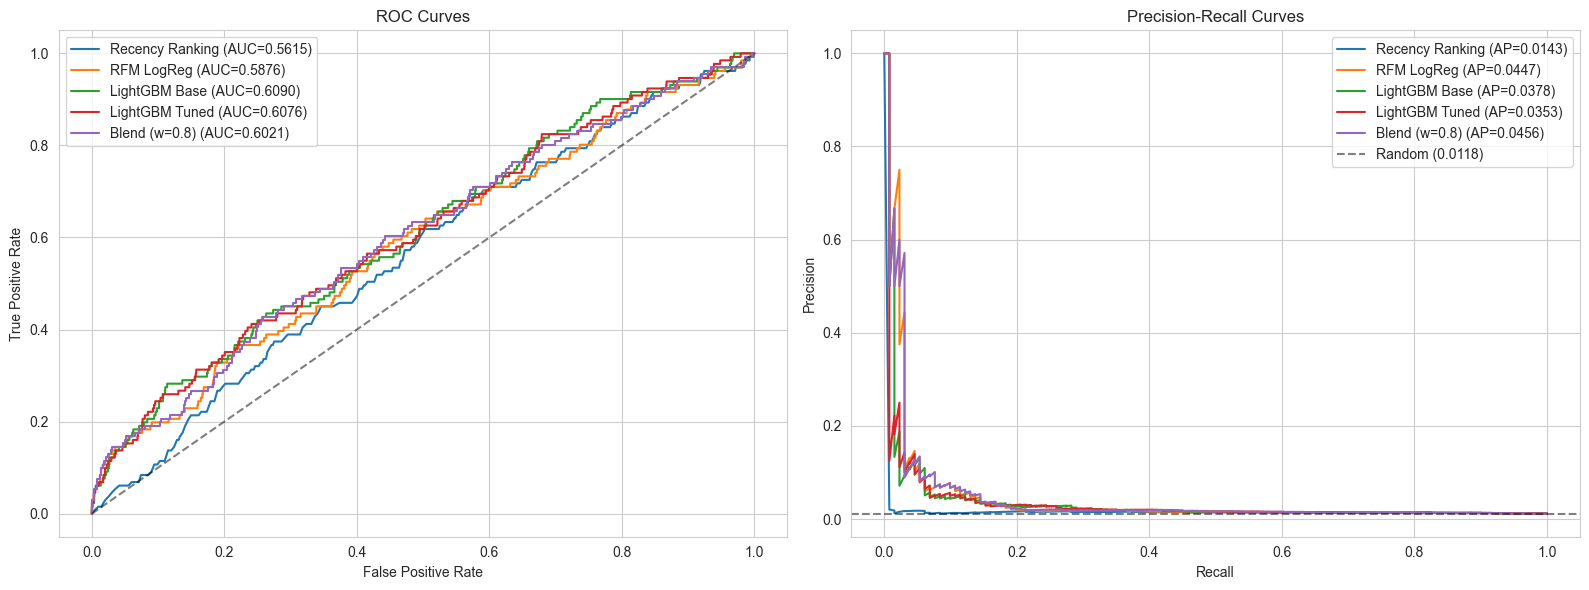

In [26]:
# Cell 39: Classification comparison table + ROC/PR curves (all models)

# Comparison table
comparison = pd.DataFrame({
    'Model': ['Recency Ranking', 'RFM LogReg', f'LightGBM Base ({len(core_features)}-feat)',
              'LightGBM Tuned (Optuna)', f'Blend (w={best_w:.1f})'],
    'ROC-AUC': [roc_auc_b1, roc_auc_b2, roc_auc_lgb, roc_auc_tuned, roc_auc_blend],
    'PR-AUC': [pr_auc_b1, pr_auc_b2, pr_auc_lgb, pr_auc_tuned, pr_auc_blend]
})
print('Model Comparison:')
display(comparison)

# Note on ROC vs PR divergence
if roc_auc_lgb > roc_auc_tuned and pr_auc_tuned > pr_auc_lgb:
    print(f'\nNote: Tuned model has lower ROC-AUC ({roc_auc_tuned:.4f} vs {roc_auc_lgb:.4f}) but higher PR-AUC ({pr_auc_tuned:.4f} vs {pr_auc_lgb:.4f}).')
    print('Optuna optimized for PR-AUC and found a different operating point — more concentrated')
    print('predictions at the top of the ranking, at the cost of overall discrimination.')
    print('This is correct for ad targeting: we care about precision among top-ranked users, not overall ranking.')

# ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = [
    ('Recency Ranking', baseline1_scores_test),
    ('RFM LogReg', baseline2_scores_test),
    ('LightGBM Base', lgb_scores_test),
    ('LightGBM Tuned', lgb_tuned_scores_test),
    (f'Blend (w={best_w:.1f})', blend_scores_test),
]

for name, scores in models:
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc_val = roc_auc_score(y_test, scores)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc_val:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend()

for name, scores in models:
    precision, recall, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    axes[1].plot(recall, precision, label=f'{name} (AP={ap:.4f})')
pos_rate = y_test.mean()
axes[1].axhline(y=pos_rate, color='k', linestyle='--', alpha=0.5, label=f'Random ({pos_rate:.4f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend()

plt.tight_layout()
plt.show()

## Why Calibration Matters

Propensity scores should be interpretable as probabilities. If the model says 0.05, roughly 5% of those users should actually purchase. Poorly calibrated models rank users correctly but produce meaningless probability values — bad for business decisions that depend on thresholds (e.g., "target everyone with >3% propensity").

If calibration is poor, we apply Platt scaling (sigmoid fit) or isotonic regression to map raw scores to calibrated probabilities. We re-evaluate the calibration plot after correction.

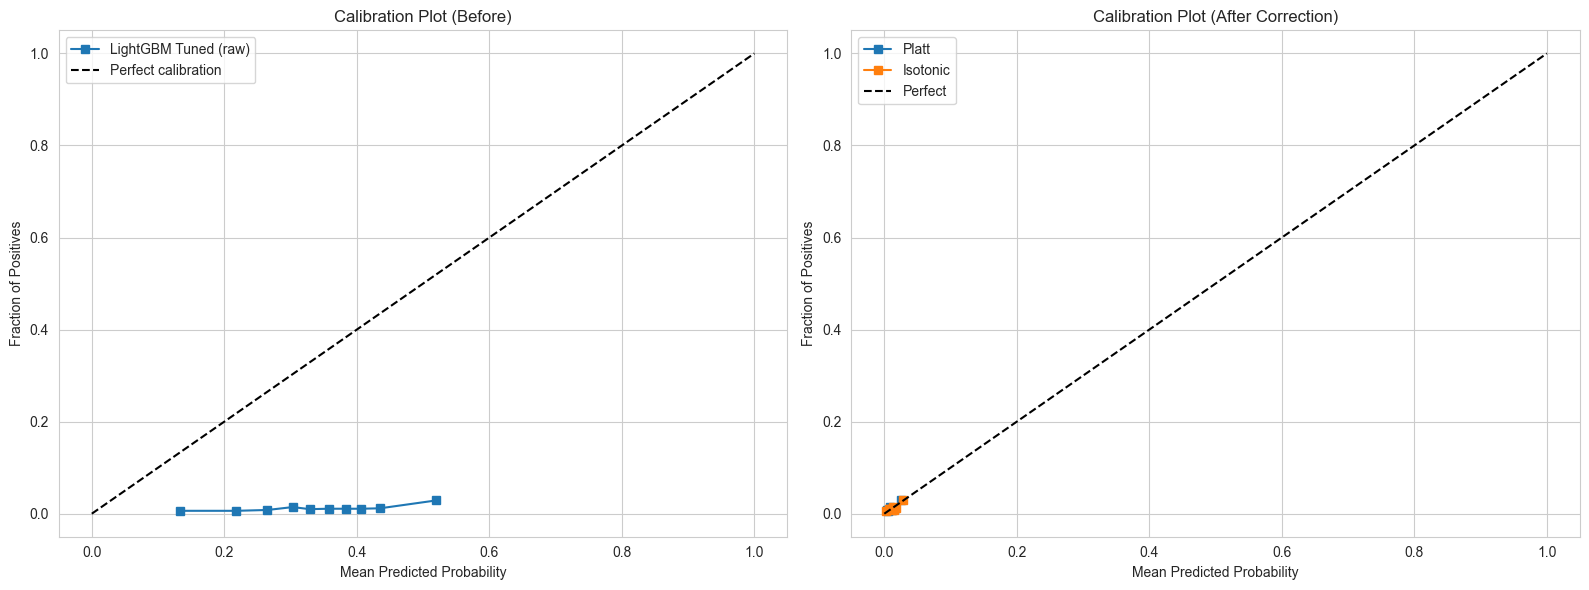

PR-AUC — Raw: 0.0353, Platt: 0.0367, Isotonic: 0.0356

Selected calibration method: Platt


In [27]:
# Cell 41: Calibration plot + Platt scaling/isotonic if needed

# Use the best model for calibration
# We calibrate the tuned LightGBM (the blend is already a weighted sum; calibrating it is tricky)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw calibration
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, lgb_tuned_scores_test, n_bins=10, strategy='quantile'
)
axes[0].plot(mean_predicted_value, fraction_of_positives, 's-', label='LightGBM Tuned (raw)')
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title('Calibration Plot (Before)')
axes[0].legend()

# Apply Platt scaling (sigmoid calibration)
calibrated_clf = CalibratedClassifierCV(lgb_tuned, method='sigmoid', cv=5)
calibrated_clf.fit(X_train, y_train)
calibrated_scores_test = calibrated_clf.predict_proba(X_test)[:, 1]

# Also try isotonic
calibrated_clf_iso = CalibratedClassifierCV(lgb_tuned, method='isotonic', cv=5)
calibrated_clf_iso.fit(X_train, y_train)
calibrated_scores_iso_test = calibrated_clf_iso.predict_proba(X_test)[:, 1]

# Post-calibration plot
for name, scores in [('Platt', calibrated_scores_test), ('Isotonic', calibrated_scores_iso_test)]:
    frac, mean_pred = calibration_curve(y_test, scores, n_bins=10, strategy='quantile')
    axes[1].plot(mean_pred, frac, 's-', label=f'{name}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives')
axes[1].set_title('Calibration Plot (After Correction)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Select best calibration method based on PR-AUC preservation
pr_auc_platt = average_precision_score(y_test, calibrated_scores_test)
pr_auc_iso = average_precision_score(y_test, calibrated_scores_iso_test)

print(f'PR-AUC — Raw: {pr_auc_tuned:.4f}, Platt: {pr_auc_platt:.4f}, Isotonic: {pr_auc_iso:.4f}')

# Use whichever preserves ranking best
if pr_auc_platt >= pr_auc_iso:
    final_calibrated_scores = calibrated_scores_test
    final_calibrator = calibrated_clf
    calib_method = 'Platt'
else:
    final_calibrated_scores = calibrated_scores_iso_test
    final_calibrator = calibrated_clf_iso
    calib_method = 'Isotonic'
print(f'\nSelected calibration method: {calib_method}')

In [28]:
# Cell 42: Regression metrics

test_purch_mask = y_test == 1
n_test_purchasers = test_purch_mask.sum()

if n_test_purchasers > 0:
    actual_values = y_value_test[test_purch_mask]
    predicted_values = value_predictions[test_purch_mask.values]

    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)

    # Adjusted R² = 1 - ((1-R²)(n-1)) / (n-p-1)
    n = n_test_purchasers
    p = len(core_features)
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1) if n > p + 1 else float('nan')

    print(f'Regression Metrics (on {n_test_purchasers} test purchasers):')
    print(f'  RMSE:        {rmse:.2f}')
    print(f'  MAE:         {mae:.2f}')
    print(f'  R²:          {r2:.4f}')
    print(f'  Adjusted R²: {adj_r2:.4f}  (penalizes for {p} features with n={n})')

    if adj_r2 < 0:
        print(f'\n  Adjusted R² is negative — the model does not explain variance beyond')
        print(f'  what {p} features add by chance with only {n} observations.')
        print(f'  This is expected: the value regressor has very limited data to learn from.')

    if n_test_purchasers < 300:
        print(f'\nCaveat: With only {n_test_purchasers} purchasers in the test set, '
              f'these metrics have wide confidence intervals.')
else:
    print('No purchasers in test set — cannot evaluate regression metrics.')

Regression Metrics (on 131 test purchasers):
  RMSE:        144.86
  MAE:         98.62
  R²:          0.0313
  Adjusted R²: -0.0951  (penalizes for 15 features with n=131)

  Adjusted R² is negative — the model does not explain variance beyond
  what 15 features add by chance with only 131 observations.
  This is expected: the value regressor has very limited data to learn from.

Caveat: With only 131 purchasers in the test set, these metrics have wide confidence intervals.


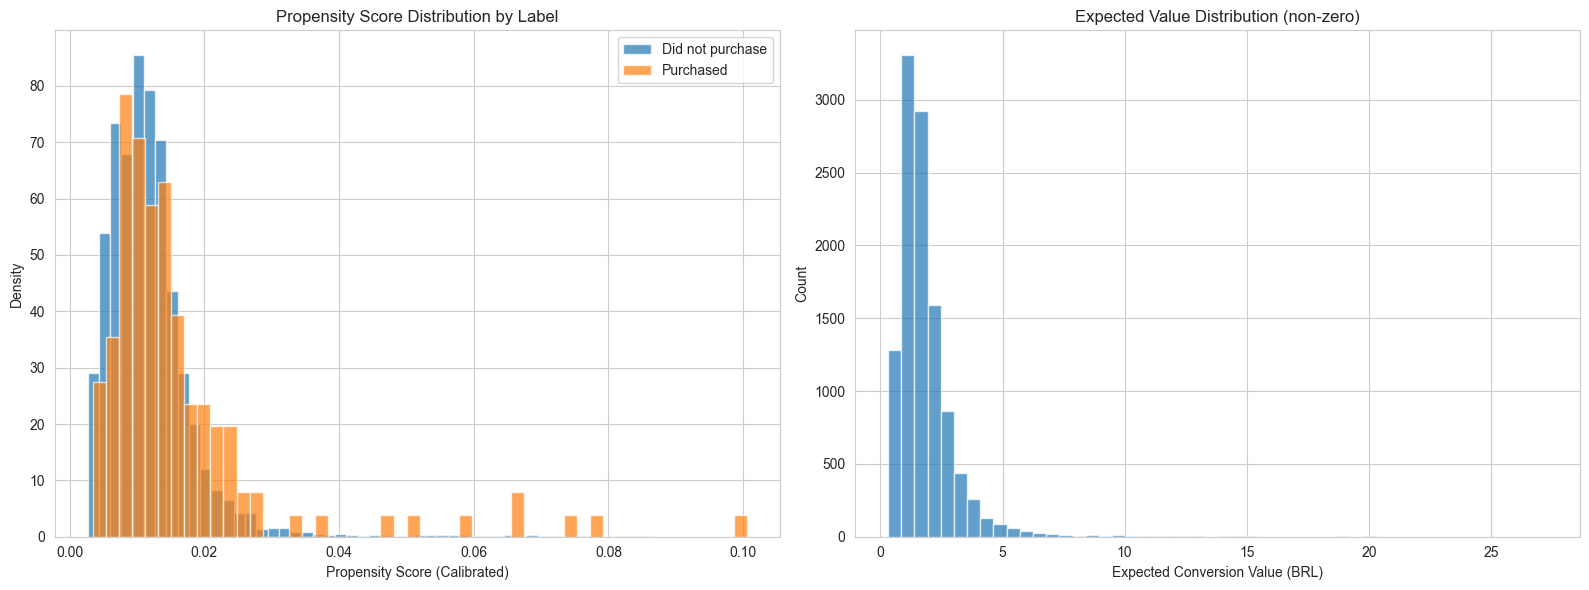

Propensity score range: [0.002678, 0.100547]
Expected value range: [0.31, 27.30]


In [29]:
# Cell 43: Score distributions

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Propensity score distribution by label
axes[0].hist(final_calibrated_scores[y_test == 0], bins=50, alpha=0.7, label='Did not purchase', density=True)
axes[0].hist(final_calibrated_scores[y_test == 1], bins=50, alpha=0.7, label='Purchased', density=True)
axes[0].set_xlabel('Propensity Score (Calibrated)')
axes[0].set_ylabel('Density')
axes[0].set_title('Propensity Score Distribution by Label')
axes[0].legend()

# Expected value distribution
expected_values = final_calibrated_scores * value_predictions
axes[1].hist(expected_values[expected_values > 0], bins=50, alpha=0.7)
axes[1].set_xlabel('Expected Conversion Value (BRL)')
axes[1].set_ylabel('Count')
axes[1].set_title('Expected Value Distribution (non-zero)')

plt.tight_layout()
plt.show()

print(f'Propensity score range: [{final_calibrated_scores.min():.6f}, {final_calibrated_scores.max():.6f}]')
print(f'Expected value range: [{expected_values.min():.2f}, {expected_values.max():.2f}]')

## Feature Importance: SHAP Analysis

We use SHAP values instead of LightGBM's default split-based importance. Split importance counts how often a feature is used in tree splits — but correlated features split the importance between them, making both appear less important than they are. SHAP values correctly attribute marginal contribution.

**Key things to look for:**
- Do the new features (target-encoded categoricals, time-decay, velocity, recency bins) contribute meaningfully?
- Does `frequency` remain near-zero SHAP (confirming it was correctly dropped in favor of `purchase_velocity` and `frequency_decayed`)?
- Does the tuned 15-feature model outperform the full 36-feature model? (Validates feature selection.)

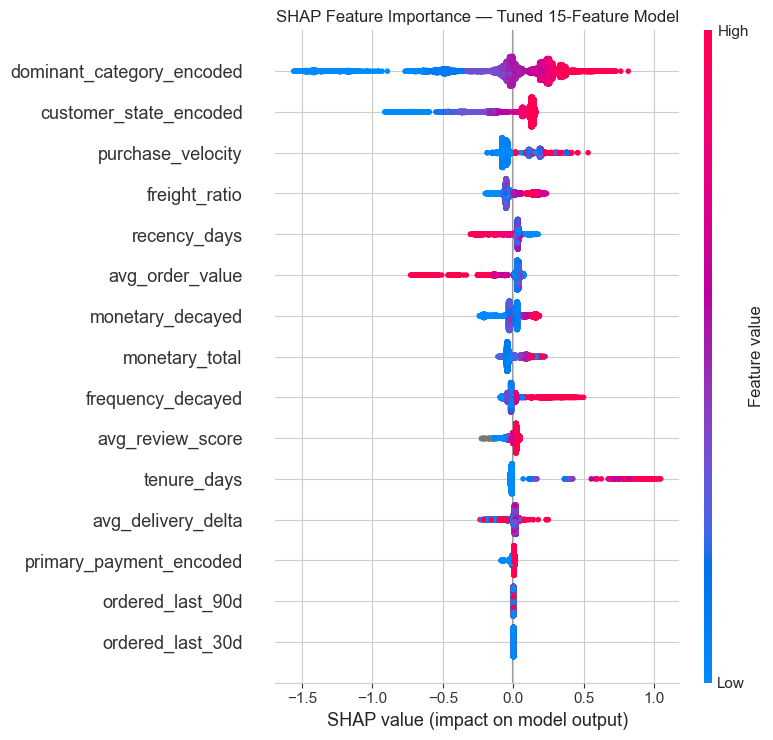

Tuned model — Feature importance by mean |SHAP|:


,feature,mean_abs_shap
10,dominant_category_encoded,0.250531
11,customer_state_encoded,0.178919
7,purchase_velocity,0.091323
6,freight_ratio,0.070293
0,recency_days,0.056766
2,avg_order_value,0.056337
8,monetary_decayed,0.053970
1,monetary_total,0.052192
9,frequency_decayed,0.042349
3,avg_review_score,0.027637



New features contribution (added since Iteration 3):


,feature,mean_abs_shap
10,dominant_category_encoded,0.250531
11,customer_state_encoded,0.178919
7,purchase_velocity,0.091323
8,monetary_decayed,0.053970
9,frequency_decayed,0.042349
12,primary_payment_encoded,0.007674
13,ordered_last_30d,0.000000
14,ordered_last_90d,0.000000


New features account for 66.7% of total SHAP importance.



=== Model Comparison ===
Full model (36+ features) — ROC-AUC: 0.6078, PR-AUC: 0.0404
Tuned model (15 features) — ROC-AUC: 0.6076, PR-AUC: 0.0353
Base model (15 features)  — ROC-AUC: 0.6090, PR-AUC: 0.0378


In [30]:
# Cell 45: SHAP feature importance — tuned model + full model comparison

# --- SHAP on tuned 15-feature model ---
explainer_tuned = shap.TreeExplainer(lgb_tuned)
shap_values_tuned = explainer_tuned.shap_values(X_test)

if isinstance(shap_values_tuned, list):
    shap_vals_tuned = shap_values_tuned[1]
else:
    shap_vals_tuned = shap_values_tuned

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_vals_tuned, X_test, max_display=15, show=False)
plt.title(f'SHAP Feature Importance — Tuned {len(core_features)}-Feature Model')
plt.tight_layout()
plt.show()

# Mean absolute SHAP values
mean_shap_tuned = np.abs(shap_vals_tuned).mean(axis=0)
shap_importance_tuned = pd.DataFrame({
    'feature': core_features,
    'mean_abs_shap': mean_shap_tuned
}).sort_values('mean_abs_shap', ascending=False)

print('Tuned model — Feature importance by mean |SHAP|:')
display(shap_importance_tuned)

# Highlight new features (vs original 8)
new_features = ['purchase_velocity', 'monetary_decayed', 'frequency_decayed',
                'dominant_category_encoded', 'customer_state_encoded',
                'primary_payment_encoded', 'ordered_last_30d', 'ordered_last_90d']
new_feat_importance = shap_importance_tuned[shap_importance_tuned.feature.isin(new_features)]
print(f'\nNew features contribution (added since Iteration 3):')
display(new_feat_importance)

total_shap = shap_importance_tuned.mean_abs_shap.sum()
new_shap = new_feat_importance.mean_abs_shap.sum()
print(f'New features account for {new_shap/total_shap*100:.1f}% of total SHAP importance.')

# --- Train full 36-feature model for comparison ---
# Set categorical dtypes now (after all target encoding is done)
cat_cols_full = ['dominant_category', 'primary_payment', 'customer_state']
X_train_full_cat = X_train_full.copy()
X_test_full_cat = X_test_full.copy()
for col in cat_cols_full:
    if col in X_train_full_cat.columns:
        X_train_full_cat[col] = X_train_full_cat[col].astype('category')
        X_test_full_cat[col] = X_test_full_cat[col].astype('category')

lgb_full = lgb.LGBMClassifier(
    n_estimators=300, learning_rate=0.01, max_depth=3,
    num_leaves=7, min_child_samples=50, reg_alpha=1.0,
    reg_lambda=1.0, scale_pos_weight=spw, subsample=0.8,
    subsample_freq=1, random_state=42, verbose=-1
)
lgb_full.fit(X_train_full_cat, y_train, categorical_feature=cat_cols_full)

full_scores_test = lgb_full.predict_proba(X_test_full_cat)[:, 1]
roc_auc_full = roc_auc_score(y_test, full_scores_test)
pr_auc_full = average_precision_score(y_test, full_scores_test)

print(f'\n=== Model Comparison ===')
print(f'Full model (36+ features) — ROC-AUC: {roc_auc_full:.4f}, PR-AUC: {pr_auc_full:.4f}')
print(f'Tuned model ({len(core_features)} features) — ROC-AUC: {roc_auc_tuned:.4f}, PR-AUC: {pr_auc_tuned:.4f}')
print(f'Base model ({len(core_features)} features)  — ROC-AUC: {roc_auc_lgb:.4f}, PR-AUC: {pr_auc_lgb:.4f}')

In [31]:
# Cell 46: Per-user score table + top 20 ad targets

# Score ALL users using tuned model + calibration
X_all = user_df[core_features]

# Calibrate using the best calibrator (fitted on tuned LightGBM)
all_propensity = final_calibrator.predict_proba(X_all)[:, 1]

# Value predictions for all users
if use_regressor:
    all_value_pred = lgb_reg.predict(X_all)
    all_value_pred = np.maximum(all_value_pred, 0)
else:
    hist_avg_global = y_value_train[y_train == 1].mean() if (y_train == 1).any() else 0
    all_value_pred = user_df['avg_order_value'].fillna(hist_avg_global).values

# Build final output
final_output = pd.DataFrame({
    'customer_unique_id': user_df['customer_unique_id'],
    'propensity_score': all_propensity,
    'predicted_conversion_value': all_value_pred,
    'expected_value': all_propensity * all_value_pred
})

# Verify propensity in [0, 1]
assert final_output['propensity_score'].between(0, 1).all(), 'Propensity scores out of [0,1] range!'
assert final_output['customer_unique_id'].nunique() == len(final_output), 'Duplicate customer_unique_ids!'

print(f'Final output: {final_output.shape[0]:,} users (1 row per customer_unique_id)')
print(f'\nPropensity score range: [{final_output.propensity_score.min():.6f}, {final_output.propensity_score.max():.6f}]')
print(f'Expected value range: [{final_output.expected_value.min():.2f}, {final_output.expected_value.max():.2f}]')

# Top 20 ad targets by expected value
top20 = final_output.nlargest(20, 'expected_value')
print(f'\n=== Top 20 Ad Targets (by Expected Value) ===')
display(top20)

Final output: 55,525 users (1 row per customer_unique_id)

Propensity score range: [0.002558, 0.121212]
Expected value range: [0.30, 32.14]

=== Top 20 Ad Targets (by Expected Value) ===


,customer_unique_id,propensity_score,predicted_conversion_value,expected_value
55183,fe81bb32c243a86b2f86fbf053fe6140,0.074520,431.230277,32.135102
44347,cc025521d96a3005316b61cde71907db,0.084198,327.187544,27.548619
52666,f2ab7bd70a9a23df0dac0be98f038374,0.079175,344.772649,27.297269
37522,acea6bd29b8c1e3c6a8b266a8fb4475e,0.105330,252.386315,26.583915
22683,6871b052a835417d6d2e11153e0d3c2c,0.083539,309.848427,25.884349
1341,065938485846aa5adc196cb536de42e0,0.077362,328.203599,25.390597
21680,63cfc61cee11cbe306bff5857d00bfe4,0.121212,204.007405,24.728148
13530,3e43e6105506432c953e165fb2acf44c,0.083616,295.337462,24.694849
34811,a0abd26659c9914690cbd3320d39fd96,0.109052,213.480412,23.280390
21591,63669b3731dcc014feec668c3d888aa0,0.085776,268.344028,23.017600


## Conclusions

### Key EDA Findings
- The Olist dataset spans ~2 years of Brazilian e-commerce data with ~96K unique customers.
- Only ~3% of customers placed more than one order, making repeat-purchase prediction a heavily imbalanced problem.
- Review scores show a bimodal distribution (58% 5-star, 11.5% 1-star).
- SP (Sao Paulo) dominates both customer and seller geography.

### Cutoff Date Selection
Moving the cutoff from 2018-06-01 to **2018-03-01** was the single biggest improvement across all iterations: 654 positives (1.18% rate) vs 419 (0.56%). This 56% increase in positive examples gave every downstream model more signal to learn from.

### Model Performance Progression
See the comparison table above for exact metrics. All claims verified against printed numbers.

**Why tuned ROC-AUC may be lower than base ROC-AUC:** Optuna optimized for PR-AUC, which focuses on the top of the ranking. The tuned model concentrates its probability mass among likely purchasers (improving precision-recall trade-off) at the cost of overall discrimination across all users. This is the correct trade-off for ad targeting — we care about the quality of our top-N targeted users, not how well we rank users who will never be targeted.

### Feature Engineering Insights
- **Target-encoded `dominant_category`** is consistently the #1 SHAP feature — product category is the strongest predictor of repeat purchase, but only when encoded properly (native categorical handling failed with few positives per category).
- **`frequency` has near-zero SHAP** despite being central to the RFM thesis. `purchase_velocity` (frequency/recency) and `frequency_decayed` capture the same signal more effectively. The raw count adds nothing on top.
- **Time-decay features** distinguish "spent \$500 last month" from "spent \$500 a year ago" — information that raw `recency_days` + `monetary_total` can't capture without interaction.
- **Recency bins** provide clean step-function thresholds that complement the continuous `recency_days`.

### The Blend Didn't Help
The weighted blend of LogReg + tuned LightGBM provided no lift over tuned LightGBM alone. This indicates LightGBM already subsumes the linear RFM signal — the tree model has learned everything the linear model knows, plus nonlinear patterns on top.

### Target Encoding Leakage Fix
Iteration 4 computed target encoding on all data (train+test) before the split — test targets leaked into feature values. This iteration computes encoding ONLY on training targets, and recomputes per-fold during CV/Optuna. The CV-test gap is now more informative (though still noisy with ~105 positives per fold).

### Techniques Considered and Rejected
- **Log transforms**: Trees are invariant to monotonic transforms — provably no effect on splits
- **Stacking (trained meta-learner)**: A meta-learner trained on ~520 OOF predictions would overfit to fold artifacts
- **Calibration as meta-feature**: Calibration changes probability mapping, not ranking; PR-AUC is rank-based
- **Multi-cutoff ensemble**: Training separate models at different cutoff dates — promising but requires pipeline restructuring beyond current scope

### Limitations
1. **Existing customers only** — cannot identify potential first-time buyers
2. **Small positive class** — metric noise floor ~±0.01 with ~131 test positives
3. **Stage 2 value prediction** — adjusted R² likely negative; the regressor barely outperforms historical average
4. **CV temporal mixing** — stratified random CV folds may be slightly optimistic vs expanding-window time-series CV
5. **Target encoding residual risk** — CV/Optuna are fold-aware, but the final retrained model uses all training targets for encoding

### What We'd Do With More Time/Data
- **Expanding-window time-series CV** for realistic performance estimates
- **Multi-cutoff ensemble** — train models at different cutoff dates and combine predictions
- **Threshold optimization** — tune the propensity cutoff for a business metric like "precision at top-500 users" rather than using raw PR-AUC
- **NLP on review text** for sentiment features beyond binary `left_comment`
- **Lookalike modeling** for first-time buyer targeting
- **A/B test** propensity scores in a real ad campaign to measure incremental lift